<a href="https://colab.research.google.com/github/MarcRupin/EconomicFeasibility/blob/NALEX-Phase-1-Feasibility-Study/NALEX_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os

drive.mount('/content/drive')
base_path = "/content/drive/My Drive/highway_economic_forecast/"
os.makedirs(base_path, exist_ok=True)

Mounted at /content/drive



Optimistic   | NPV: 3,385,364,311,881,641.50 Php | BCR: 22828.81


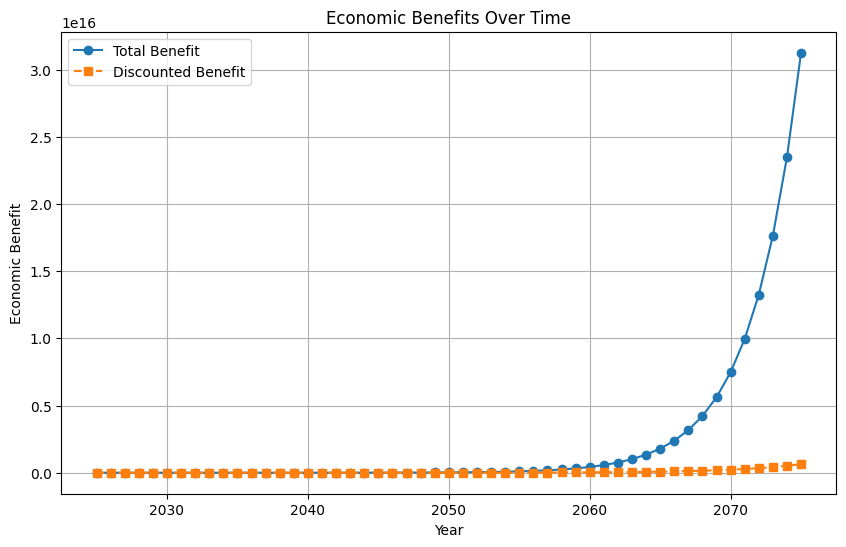

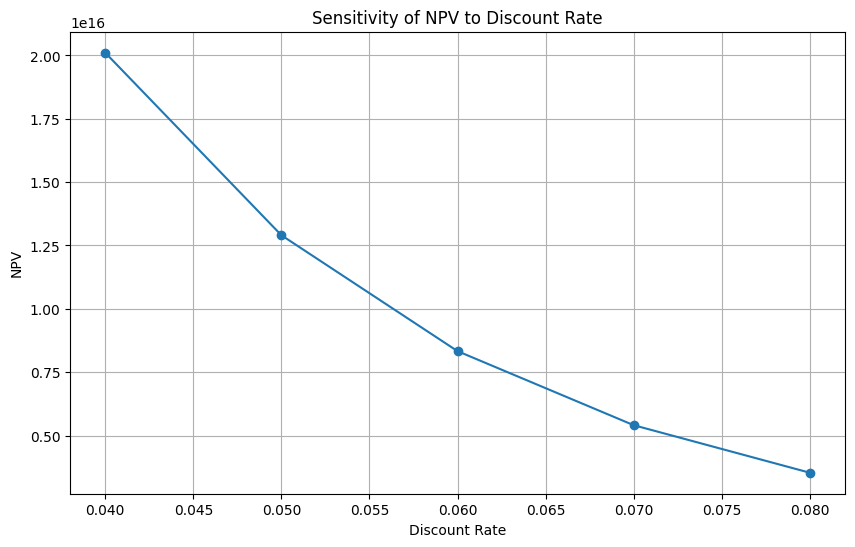


Base Case    | NPV: 282,719,580,248.23 Php | BCR: 2.91


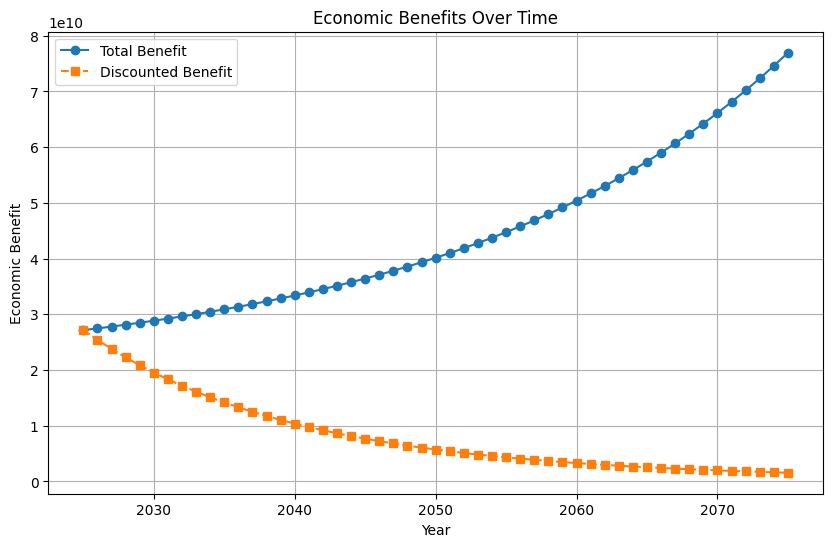

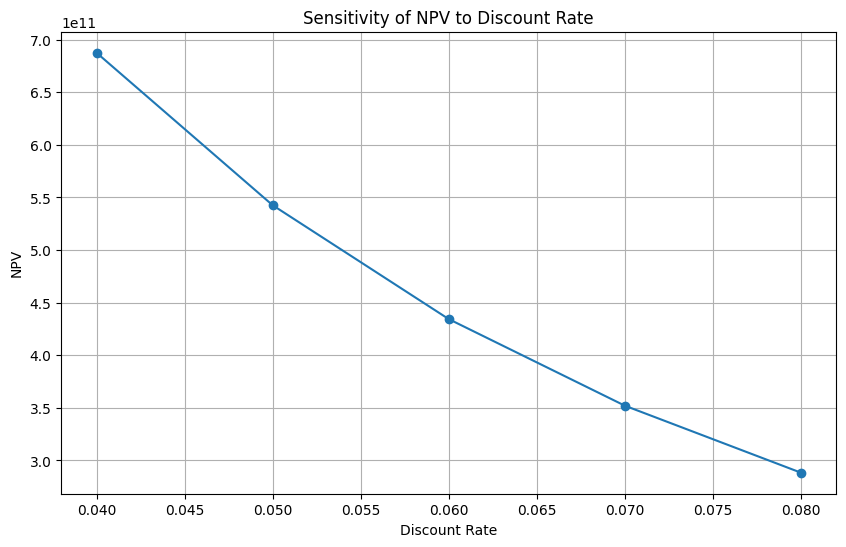


Pessimistic  | NPV: 220,469,771,647.55 Php | BCR: 2.49


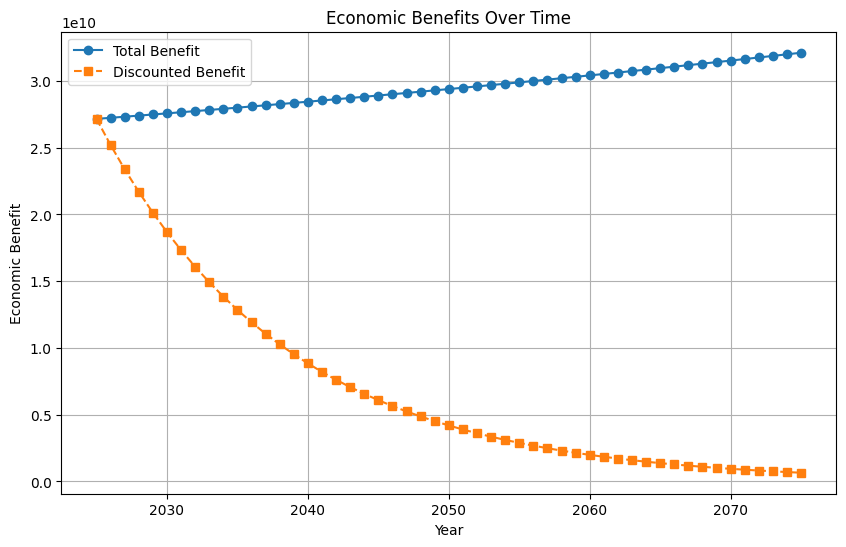

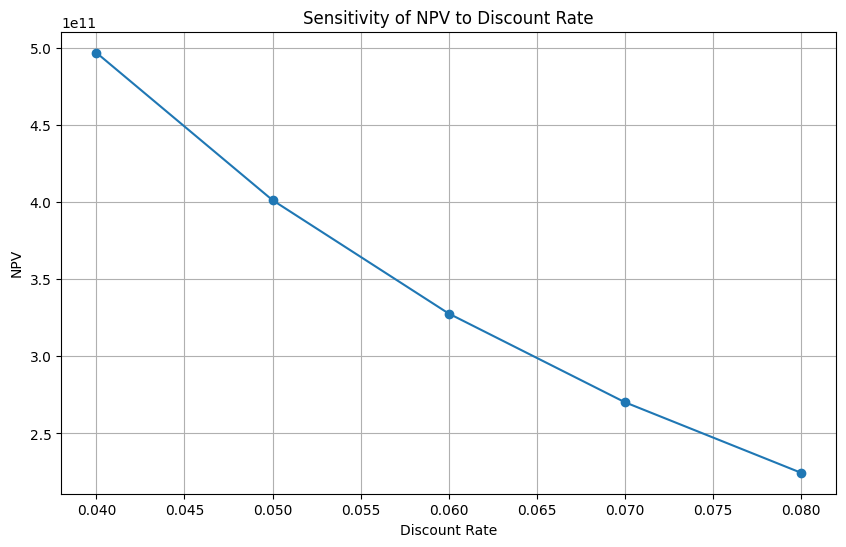

In [ ]:
# Define parameters
years = np.arange(2025, 2076)  # Forecasting period (2025-2075)
discount_rate = 0.081  # 8.1% discount rate; https://psa.gov.ph/content/summary-inflation-report-consumer-price-index-2018100-december-2023 , initial discount rate only
capex_php = 148.3e9  # Capital Expenditure: https://trb.gov.ph/index.php/toll-road-projects/northern-access-link-expresswa

# Assumed annual growth rates
land_value_growth = 0.056  # https://www.bsp.gov.ph/Media_And_Research/Media%20Releases/2024_06/news-06282024d1.aspx
business_growth = 0.1216  # Employment Generation (https://cmci.dti.gov.ph/data-portal-process.php)
job_creation_impact = 32369246.51*136.4  # Initial value of work from price/km of new road construction from Table 10 of DPWH: https://www.dpwh.gov.ph/dpwh/DPWH_ATLAS/Tables%20&%20Graphs%20(Roads)/Road%20Data%202016/ATLAS%202016/Table%201.4.htm
traffic_savings_growth = discount_rate

# Initial economic values
initial_land_value = (136.4*1000*6.70*6000) # kilometers covered by NALEX, multiplied by the span of the NALEX (6.7 km) (TRB, 2021), multiplied by the highest zonal value of Hagonoy, Bulacan (Php 6000 per sq. km.) (BIR, n.d.), multiplied by 1000 https://zonalvaluefinderph.com/zonal-values/?city=HAGONOY&province=BULACAN#
business_expansion = ((402416*1000*18.18)+(3838*1000*16.58)+(54806.57*40450073390/300345.65))  # volume of production of agricultural products of Bulacan in metric tons (402,416 for palay, 3,838 for corn) multiplied by their unit price (Php 18.18 and Php 16.58 respectively), multiplied by 1000 each volume of production of aquaculture products of Bulacan in metric tons (54,806.57), multiplied by the aquaculture volume value (Php 40,450,073.39), divided by the volume of production of agricultural products in Region III (300,345.65 MT), as mentioned in the 2022 Report of the Bureau of Fisheries and Aquatic Resources.
traffic_savings = 2500000000.00  # Lost value in traffic https://www2.jica.go.jp/en/evaluation/pdf/2022_PH-P276_1_s.pdf

def compute_economic_impact(growth_factors):
    """Computes economic impact for a given set of growth factors."""
    data = []
    for year in years:
        discount_factor = 1 / ((1 + discount_rate) ** (year - 2025))
        land_value = initial_land_value * (1 + growth_factors['land']) ** (year - 2025)
        business_value = business_expansion * (1 + growth_factors['business']) ** (year - 2025)
        traffic_savings_yearly = traffic_savings * (1 + growth_factors['traffic']) ** (year - 2025)
        job_impact = job_creation_impact * (1 + growth_factors['business']) ** (year - 2025)
        total_benefit = land_value + business_value + traffic_savings + job_impact
        discounted_benefit = total_benefit * discount_factor
        data.append([year, land_value, business_value, traffic_savings, job_impact, total_benefit, discounted_benefit])
    return pd.DataFrame(data, columns=["Year", "Land Value", "Business Growth", "Traffic Savings", "Job Creation Impact", "Total Benefit", "Discounted Benefit"])

def compute_npv_bcr(df):
    """Computes Net Present Value (NPV) and Benefit-Cost Ratio (BCR)."""
    npv = df["Discounted Benefit"].sum() - capex_php
    bcr = df["Discounted Benefit"].sum() / capex_php
    return npv, bcr

def sensitivity_analysis(df):
    """Performs sensitivity analysis by varying discount rates."""
    sensitivity_rates = [0.04, 0.05, 0.06, 0.07, 0.08] #
    npv_sensitivity = {}
    for rate in sensitivity_rates:
        discount_factors = 1 / ((1 + rate) ** (years - 2025))
        discounted_benefits = df["Total Benefit"].values * discount_factors
        npv_sensitivity[rate] = discounted_benefits.sum() - capex_php
    return npv_sensitivity

def plot_results(df, npv_sensitivity):
    """Plots economic impact and sensitivity analysis."""
    df_grouped = df.groupby("Year").sum()
    plt.figure(figsize=(10, 6))
    plt.plot(df_grouped.index, df_grouped["Total Benefit"], label="Total Benefit", linestyle='-', marker='o')
    plt.plot(df_grouped.index, df_grouped["Discounted Benefit"], label="Discounted Benefit", linestyle='--', marker='s')
    plt.xlabel("Year")
    plt.ylabel("Economic Benefit")
    plt.title("Economic Benefits Over Time")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(npv_sensitivity.keys(), npv_sensitivity.values(), marker='o', linestyle='-')
    plt.xlabel("Discount Rate")
    plt.ylabel("NPV")
    plt.title("Sensitivity of NPV to Discount Rate")
    plt.grid()
    plt.show()

# Scenario Analysis
growth_scenarios = {
    "Optimistic": {"land": 0.0817, "business": 0.3312, "traffic": 0.0231},
    "Base Case": {"land": 0.046, "business": 0.0032, "traffic": 0.0132},
    "Pessimistic": {"land": 0.0103, "business": 0.0013, "traffic": 0.0001}
} # https://cmci.dti.gov.ph/data-portal.php, choose Hagonoy (BU), For Business (Opt: 0.3312 [2020], Base: 0.0032 [2021], Pes: 0.0013 [2023]), using the local economy growth factor in the CMCI data for Hagonoy (BU).
# For traffic, use the Road Network factor in the CMCI data for Hagonoy (BU) (Opt: 0.0231 [2021], Base: 0.0132 [2019], Pes: 0.0001 [2020]).
# For Land, use the Statista Change in Land Price dataset: https://www.statista.com/statistics/1451182/philippines-quarterly-change-in-land-prices/  (Opt: 0.0817 [2019], Base: 0.046 [2022], Pes: 0.0103 [2021]).

from multiprocessing import Pool

def run_scenario(scenario_data):
    scenario, growth_factors = scenario_data
    df = compute_economic_impact(growth_factors)
    npv, bcr = compute_npv_bcr(df)
    npv_sensitivity = sensitivity_analysis(df)
    print("\n{:<12} | NPV: {:,.2f} Php | BCR: {:.2f}".format(scenario, npv, bcr))
    plot_results(df, npv_sensitivity)
    plt.close("all")
    df.to_csv(f"{base_path}highway_economic_forecast_{scenario}.csv", index=False)

if __name__ == "__main__":
    for scenario_data in growth_scenarios.items():
        run_scenario(scenario_data)



Optimistic - Road Built After 0 Years | NPV: 3,385,375,434,211,779.00 Php | BCR: 22828.89

Base Case - Road Built After 0 Years | NPV: 288,378,426,940.52 Php | BCR: 2.94

Pessimistic - Road Built After 0 Years | NPV: 220,507,019,937.80 Php | BCR: 2.49


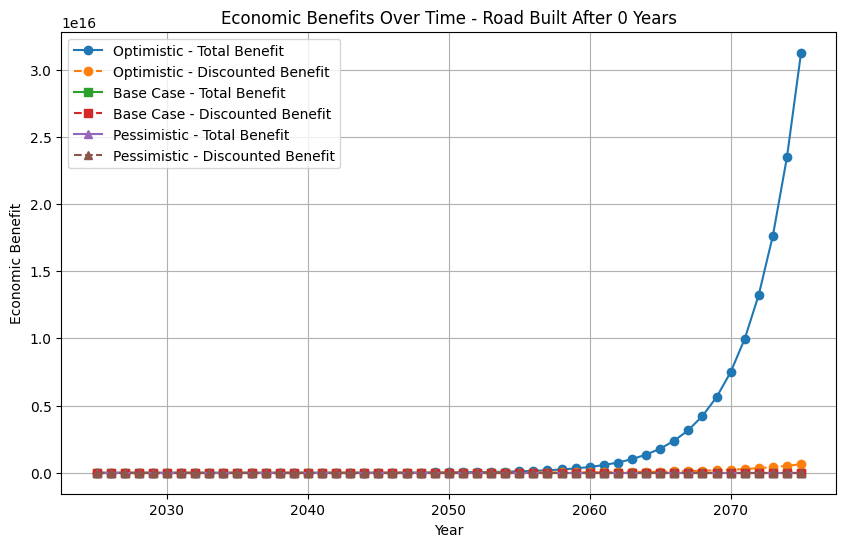

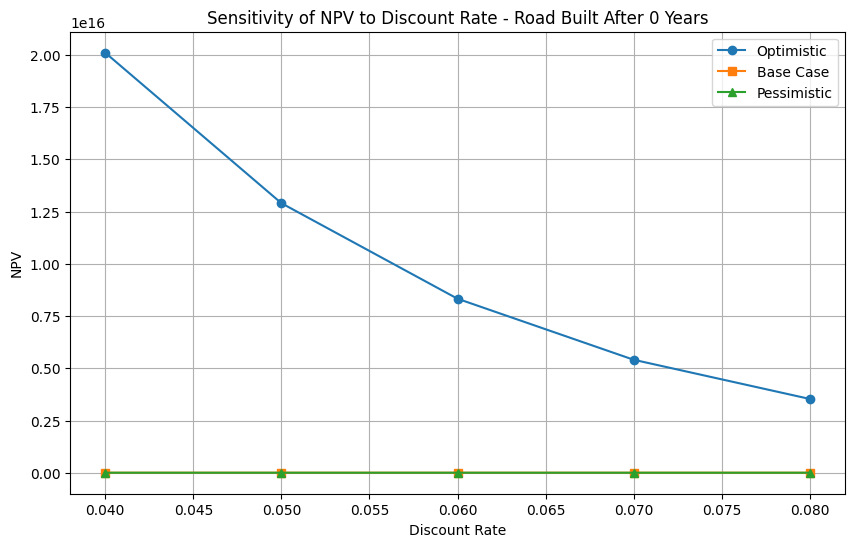


Optimistic - Road Built After 10 Years | NPV: 193,847,630,049,321.78 Php | BCR: 1308.13

Base Case - Road Built After 10 Years | NPV: 238,943,995,380.96 Php | BCR: 2.61

Pessimistic - Road Built After 10 Years | NPV: 212,785,218,305.02 Php | BCR: 2.43


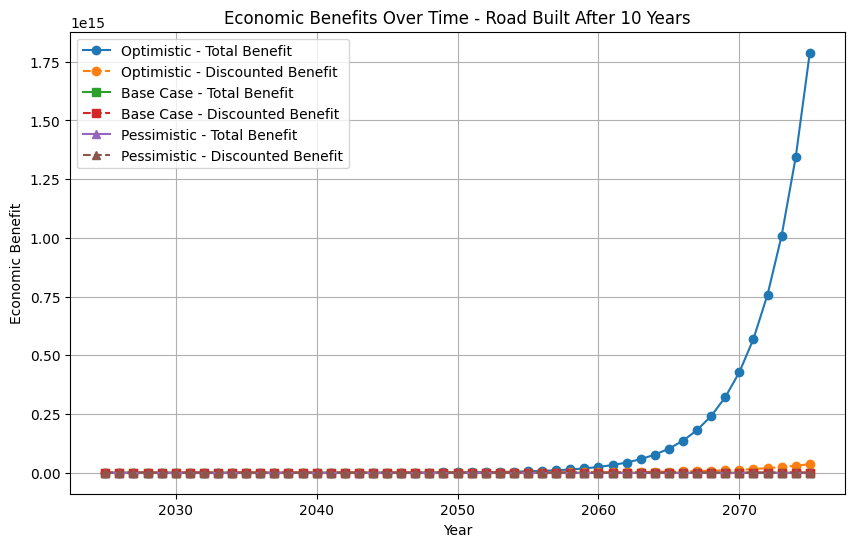

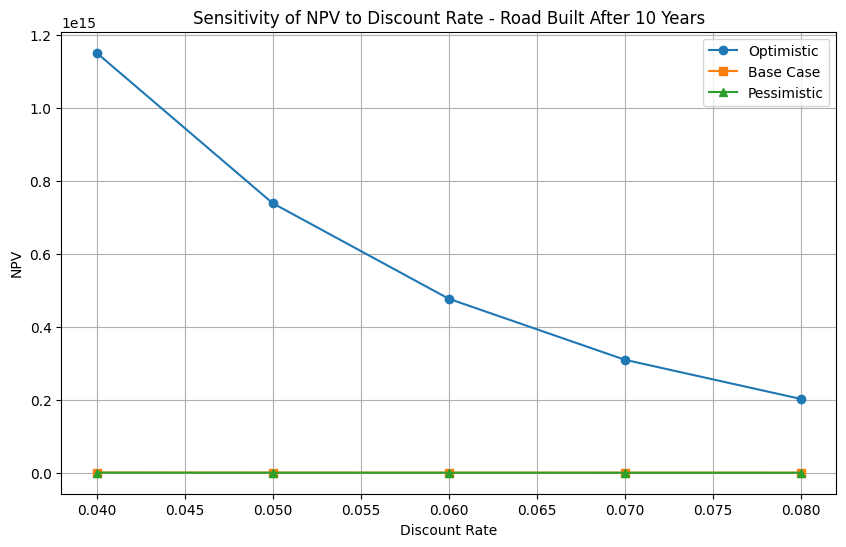


Optimistic - Road Built After 15 Years | NPV: 46,489,094,527,593.73 Php | BCR: 314.48

Base Case - Road Built After 15 Years | NPV: 226,419,030,171.63 Php | BCR: 2.53

Pessimistic - Road Built After 15 Years | NPV: 210,736,825,946.16 Php | BCR: 2.42


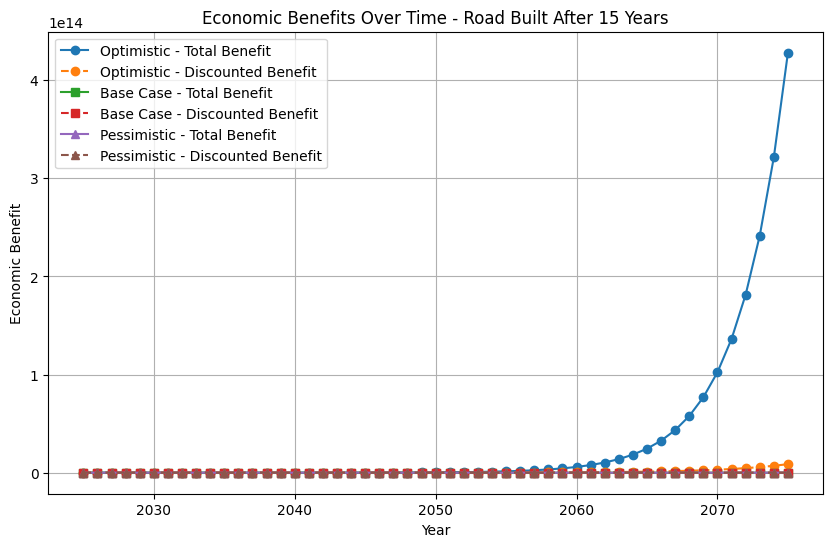

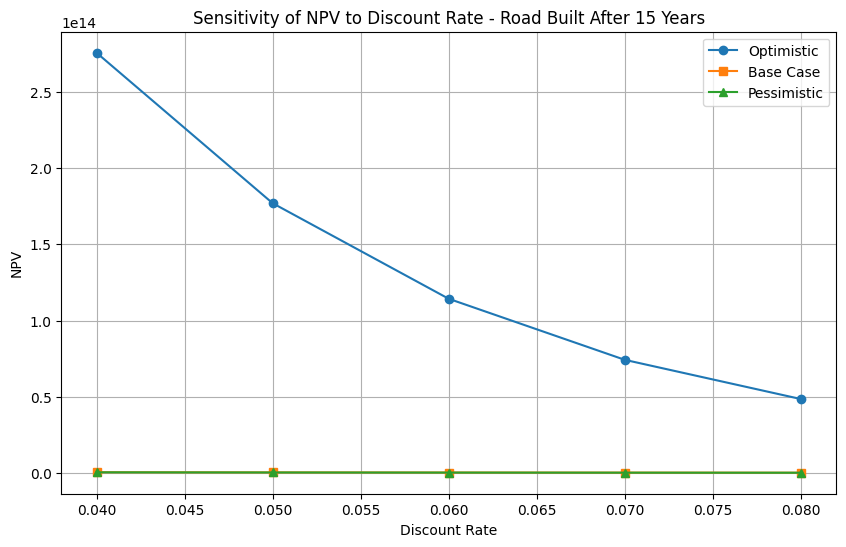

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

years = np.arange(2025, 2076)  # Forecasting period (2025-2075)
discount_rate = 0.081  # 8.1% discount rate https://psa.gov.ph/content/summary-inflation-report-consumer-price-index-2018100-december-2023 , initial discount rate only
capex_php = 148.3e9  # Capital Expenditure https://trb.gov.ph/index.php/toll-road-projects/northern-access-link-expresswa

job_creation_impact = 32369246.51 * 136.4 # # Initial value of work from price/km of new road construction from Table 10 of DPWH: https://www.dpwh.gov.ph/dpwh/DPWH_ATLAS/Tables%20&%20Graphs%20(Roads)/Road%20Data%202016/ATLAS%202016/Table%201.4.htm
traffic_savings_growth = discount_rate # 8.1% discount rate

initial_land_value = (136.4 * 1000 * 6.70 * 6000) # kilometers covered by NALEX, multiplied by the span of the NALEX (6.7 km) (TRB, 2021), multiplied by the highest zonal value of Hagonoy, Bulacan (Php 6000 per sq. km.) (BIR, n.d.), multiplied by 1000 https://zonalvaluefinderph.com/zonal-values/?city=HAGONOY&province=BULACAN#
business_expansion = ((402416 * 1000 * 18.18) + (3838 * 1000 * 16.58) + (54806.57 * 40450073390 / 300345.65))
# volume of production of agricultural products of Bulacan in metric tons (402,416 for palay, 3,838 for corn) multiplied by their unit price (Php 18.18 and Php 16.58 respectively), multiplied by 1000 each volume of production of aquaculture products of Bulacan in metric tons (54,806.57), multiplied by the aquaculture volume value (Php 40,450,073.39), divided by the volume of production of agricultural products in Region III (300,345.65 MT), as mentioned in the 2022 Report of the Bureau of Fisheries and Aquatic Resources.

traffic_savings = 2500000000.00 # https://www2.jica.go.jp/en/evaluation/pdf/2022_PH-P276_1_s.pdf

def compute_economic_impact(growth_factors):
    """Computes economic impact for a given set of growth factors with delay."""
    data = []
    for year in years:
        discount_factor = 1 / ((1 + discount_rate) ** (year - 2025))
        if year < 2025 + growth_delay:
            land_value = initial_land_value
            business_value = business_expansion
            traffic_savings_yearly = traffic_savings
            job_impact = job_creation_impact
        else:
            land_value = initial_land_value * (1 + growth_factors['land']) ** (year - (2025 + growth_delay))
            business_value = business_expansion * (1 + growth_factors['business']) ** (year - (2025 + growth_delay))
            traffic_savings_yearly = traffic_savings * (1 + growth_factors['traffic']) ** (year - (2025 + growth_delay))
            job_impact = job_creation_impact * (1 + growth_factors['business']) ** (year - (2025 + growth_delay))

        total_benefit = land_value + business_value + traffic_savings_yearly + job_impact
        discounted_benefit = total_benefit * discount_factor
        data.append([year, land_value, business_value, traffic_savings_yearly, job_impact, total_benefit, discounted_benefit])

    return pd.DataFrame(data, columns=["Year", "Land Value", "Business Growth", "Traffic Savings", "Job Creation Impact", "Total Benefit", "Discounted Benefit"])

def compute_npv_bcr(df):
    """Computes Net Present Value (NPV) and Benefit-Cost Ratio (BCR)."""
    npv = df["Discounted Benefit"].sum() - capex_php
    bcr = df["Discounted Benefit"].sum() / capex_php
    return npv, bcr

def plot_results(dfs, scenario_name, delay):
    """Plots economic impact for all growth scenarios within a built year."""
    plt.figure(figsize=(10, 6))
    markers = {'Optimistic': 'o', 'Base Case': 's', 'Pessimistic': '^'}
    for scenario, df in dfs.items():
        plt.plot(df["Year"], df["Total Benefit"], label=f"{scenario} - Total Benefit", marker=markers[scenario])
        plt.plot(df["Year"], df["Discounted Benefit"], label=f"{scenario} - Discounted Benefit", linestyle='--', marker=markers[scenario])

    plt.xlabel("Year")
    plt.ylabel("Economic Benefit")
    plt.title(f"Economic Benefits Over Time - Road Built After {delay} Years")
    plt.legend()
    plt.grid()
    plt.show()

def sensitivity_analysis(df):
    """Performs sensitivity analysis by varying discount rates."""
    sensitivity_rates = [0.04, 0.05, 0.06, 0.07, 0.08] #
    npv_sensitivity = {}
    for rate in sensitivity_rates:
        discount_factors = 1 / ((1 + rate) ** (years - 2025))
        discounted_benefits = df["Total Benefit"].values * discount_factors
        npv_sensitivity[rate] = discounted_benefits.sum() - capex_php
    return npv_sensitivity

def plot_sensitivity(npv_sensitivities, delay):
    """Plots sensitivity analysis for all scenarios within a built year."""
    plt.figure(figsize=(10, 6))
    markers = {'Optimistic': 'o', 'Base Case': 's', 'Pessimistic': '^'}
    for scenario, npv_sensitivity in npv_sensitivities.items():
        plt.plot(npv_sensitivity.keys(), npv_sensitivity.values(), label=f"{scenario}", marker=markers[scenario])

    plt.xlabel("Discount Rate")
    plt.ylabel("NPV")
    plt.title(f"Sensitivity of NPV to Discount Rate - Road Built After {delay} Years")
    plt.legend()
    plt.grid()
    plt.show()

growth_scenarios = {
    "Optimistic": {"land": 0.0817, "business": 0.3312, "traffic": 0.0231},
    "Base Case": {"land": 0.046, "business": 0.0032, "traffic": 0.0132},
    "Pessimistic": {"land": 0.0103, "business": 0.0013, "traffic": 0.0001}

}
# https://cmci.dti.gov.ph/data-portal.php, choose Hagonoy (BU), For Business (Opt: 0.3312 [2020], Base: 0.0032 [2021], Pes: 0.0013 [2023]), using the local economy growth factor in the CMCI data for Hagonoy (BU).
# For traffic, use the Road Network factor in the CMCI data for Hagonoy (BU) (Opt: 0.0231 [2021], Base: 0.0132 [2019], Pes: 0.0001 [2020]).
# For Land, use the Statista Change in Land Price dataset: https://www.statista.com/statistics/1451182/philippines-quarterly-change-in-land-prices/  (Opt: 0.0817 [2019], Base: 0.046 [2022], Pes: 0.0103 [2021]).

delays = [0, 10, 15] # this code displays the set amount of years if NALEX will be built for certain number of years (either no delay, 10 years from now, and 15 years from now)

for delay in delays:
    dfs = {}
    npv_sensitivities = {}
    for scenario, growth_factors in growth_scenarios.items():
        df = compute_economic_impact(growth_factors, delay)
        npv, bcr = compute_npv_bcr(df)
        print("\n{:<30} | NPV: {:,.2f} Php | BCR: {:.2f}".format(f"{scenario} - Road Built After {delay} Years", npv, bcr))
        dfs[scenario] = df
        npv_sensitivities[scenario] = sensitivity_analysis(df)

    plot_results(dfs, "Growth Scenarios", delay)
    plot_sensitivity(npv_sensitivities, delay)


    Year  Base Mean  Base Lower (5%)  Base Upper (95%)  Optimistic Mean  \
0   2025   0.031499         0.031499          0.031499         0.031499   
1   2026   0.056702         0.025681          0.090046         0.049849   
2   2027   0.067868         0.034953          0.100891         0.062151   
3   2028   0.072514         0.034648          0.101524         0.068555   
4   2029   0.075792         0.043181          0.109870         0.068623   
5   2030   0.073363         0.035964          0.110169         0.068563   
6   2031   0.071699         0.036533          0.103268         0.067557   
7   2032   0.073432         0.041856          0.110231         0.067757   
8   2033   0.077893         0.044970          0.109670         0.067257   
9   2034   0.077980         0.044785          0.111166         0.069229   
10  2035   0.075637         0.039422          0.108707         0.067276   
11  2036   0.076641         0.038999          0.112952         0.066460   
12  2037   0.074915      

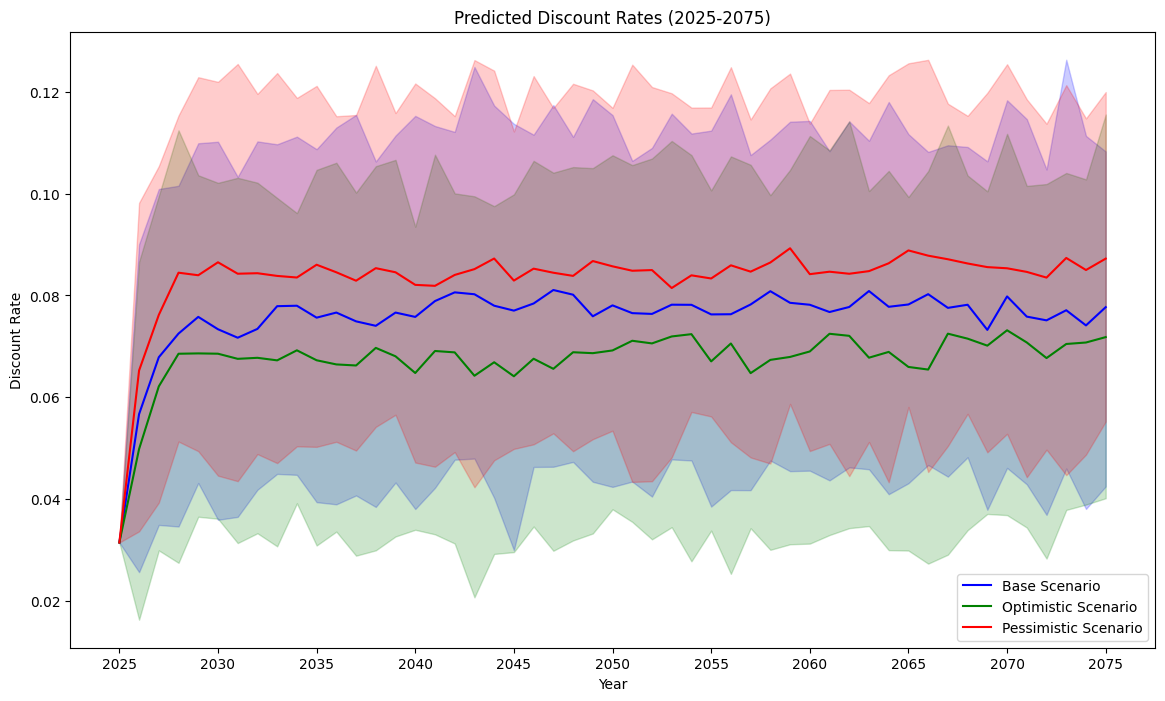

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

years = np.array([1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,
                  1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,
                  1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,
                  1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,
                  2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
                  2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,
                  2020,2021,2022,2023, 2024]) # https://www.macrotrends.net/global-metrics/countries/PHL/philippines/inflation-rate-cpi
inflation_rates = np.array([4.15482177982161,1.59563300452722,5.79665220101376,5.62554937008824,8.1830790570033,2.56410256428449,
                            5.39999999968075,6.25395319397734,2.35880645890594,1.95551032285384,14.3814616757328,21.4033435366143,
                            8.20403413498834,16.5800322638464,34.1635916359165,6.76140270456077,9.19922713611011,9.89875159736566,
                            7.33452593917692,17.5333333327501,18.2005104938508,13.0825985241676,10.2217271376892,10.0293565620481,
                            50.3389756374498,23.1031071803888,1.14813777653338,4.06976744186024,13.8600691673319,12.2429906542055,
                            12.1773522064946,19.2614585266282,8.65100357865265,6.71631104109973,10.3864734299517,6.83199610989534,
                            7.4761037778791,5.59025939650601,9.23493432267121,5.93904901780808,3.9771250324928,5.34550195567142,
                            2.72277227722765,2.28915662650607,4.82921083627795,6.51685393258433,5.4852320675105,2.90000000000003,
                            8.26044703595725,4.21903052064628,3.78983634797591,4.7184170471842,3.02696391124796,2.58268766141795,
                            3.59782343864211,0.674192536845408,1.25369880080982,2.85318772590947,5.30934661627707,2.39206534422404,
                            2.3931623931624,3.92718022100332,5.82115811213955,5.97802515541409, 3.2])

# Vasicek model is used to forecast inflation rates with unpredictability over a certain number of simulations
returns = np.log(1 + inflation_rates / 100)

def negative_log_likelihood(params): # to prevent negative values in terms of inflation; used to measure the likelihood (probability) of a model given some data by minimizing the negative of the sum of squared errors,
    alpha, theta, sigma = params
    dt = 1 # time difference between years (1 year)
    residuals = np.diff(returns) - alpha * (theta - returns[:-1]) * dt #difference between the actual changes of inflation and the predicted changes of inflation
    return np.sum(residuals**2) # sum of all the squared residuals to get a single number that represents the total error; smaller sum means better prediction of model to actual data

initial_guess = [0.1, 0.05, 0.02] # initial guess since any values will be used to numerically model constants based on historical data (inflation rates)
result = minimize(negative_log_likelihood, initial_guess, bounds=[(0, None), (None, None), (0, None)])
alpha, theta, sigma = result.x

def simulate_vasicek(r0, alpha, theta, sigma, years, n_simulations=100):
    simulations = np.zeros((n_simulations, len(years)))
    for i in range(n_simulations):
        rates = np.zeros(len(years))
        rates[0] = r0
        for t in range(1, len(years)):
            dW = np.random.normal(0, 1)
            dt = years[t] - years[t - 1]
            rates[t] = rates[t - 1] + alpha * (theta - rates[t - 1]) * dt + sigma * np.sqrt(dt) * dW
        simulations[i, :] = rates
    return simulations

r0 = returns[-1] # returns the value at the end of the array
future_years = np.arange(2025, 2076)

base_simulations = simulate_vasicek(r0, alpha, theta, sigma, future_years)
optimistic_simulations = simulate_vasicek(r0, alpha, theta * 0.9, sigma, future_years)
pessimistic_simulations = simulate_vasicek(r0, alpha, theta * 1.1, sigma, future_years)

predictions = {
    "Year": future_years,
    "Base Mean": np.mean(base_simulations, axis=0),
    "Base Lower (5%)": np.percentile(base_simulations, 5, axis=0),
    "Base Upper (95%)": np.percentile(base_simulations, 95, axis=0),
    "Optimistic Mean": np.mean(optimistic_simulations, axis=0),
    "Optimistic Lower (5%)": np.percentile(optimistic_simulations, 5, axis=0),
    "Optimistic Upper (95%)": np.percentile(optimistic_simulations, 95, axis=0),
    "Pessimistic Mean": np.mean(pessimistic_simulations, axis=0),
    "Pessimistic Lower (5%)": np.percentile(pessimistic_simulations, 5, axis=0),
    "Pessimistic Upper (95%)": np.percentile(pessimistic_simulations, 95, axis=0)
}
predictions_df = pd.DataFrame(predictions)
print(predictions_df)

plt.figure(figsize=(14, 8))
plt.plot(future_years, predictions_df["Base Mean"], label='Base Scenario', color='blue')
plt.fill_between(future_years, predictions_df["Base Lower (5%)"], predictions_df["Base Upper (95%)"], color='blue', alpha=0.2)
plt.plot(future_years, predictions_df["Optimistic Mean"], label='Optimistic Scenario', color='green')
plt.fill_between(future_years, predictions_df["Optimistic Lower (5%)"], predictions_df["Optimistic Upper (95%)"], color='green', alpha=0.2)
plt.plot(future_years, predictions_df["Pessimistic Mean"], label='Pessimistic Scenario', color='red')
plt.fill_between(future_years, predictions_df["Pessimistic Lower (5%)"], predictions_df["Pessimistic Upper (95%)"], color='red', alpha=0.2)
plt.title('Predicted Discount Rates (2025-2075)')
plt.xlabel('Year')
plt.ylabel('Discount Rate')
plt.xticks(np.arange(2025, 2076, 5))
plt.legend()
plt.show()



Optimistic Scenario - NPV: 1,903,537,829,735.10 Php | BCR: 13.84


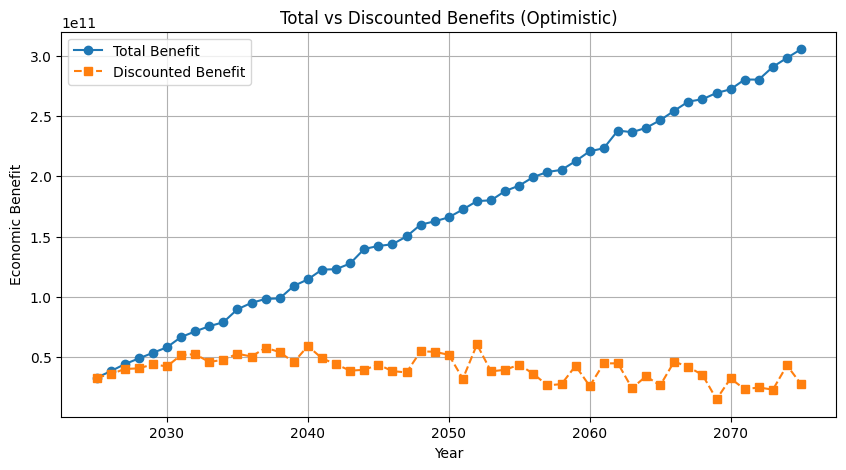

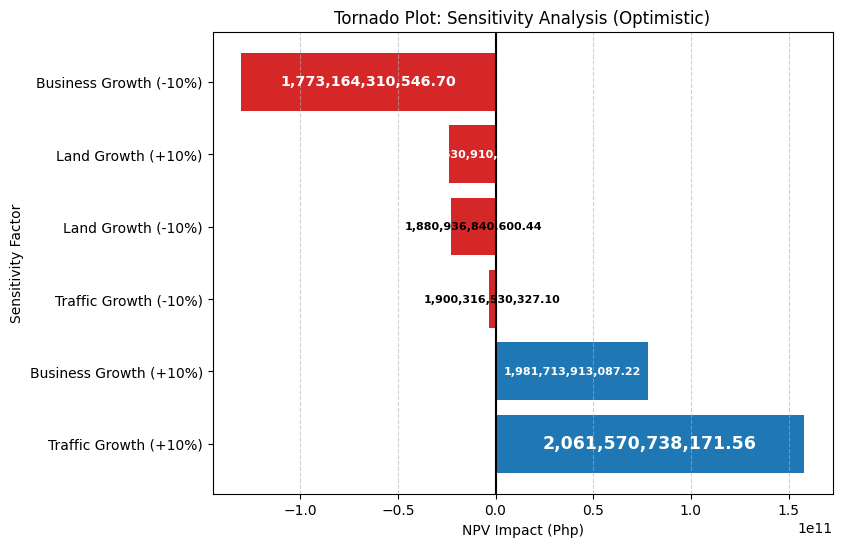


Base Case Scenario - NPV: 1,718,526,578,351.93 Php | BCR: 12.59


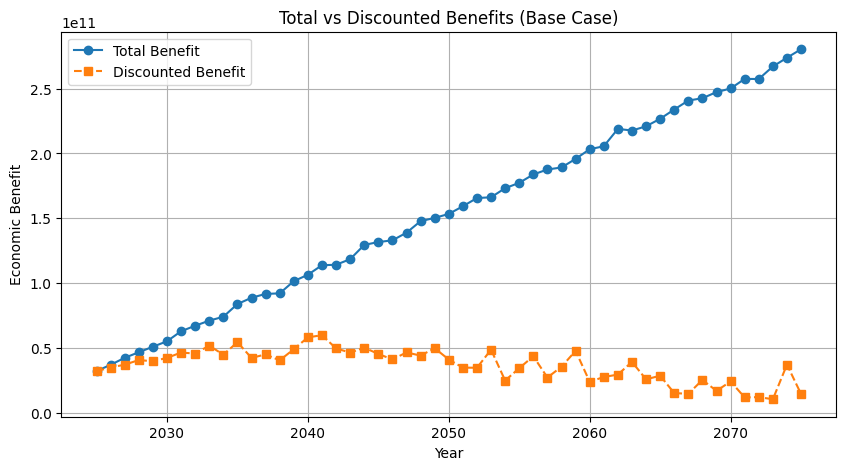

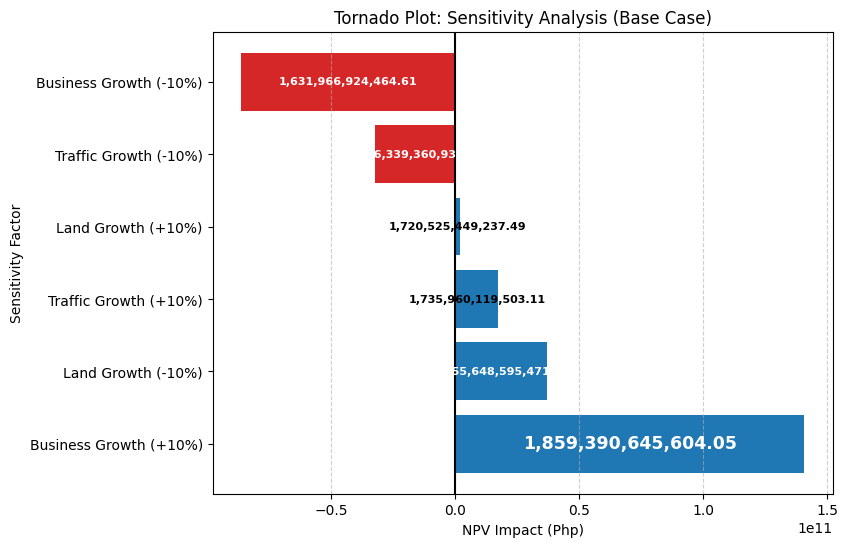


Pessimistic Scenario - NPV: 1,568,641,839,232.13 Php | BCR: 11.58


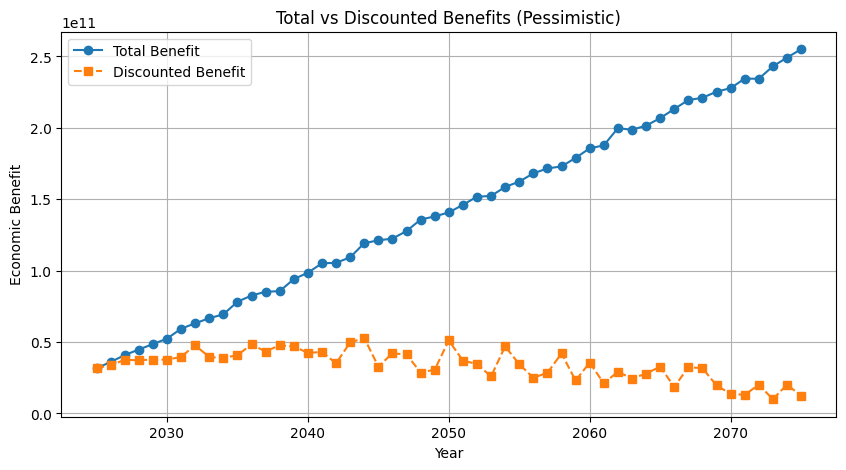

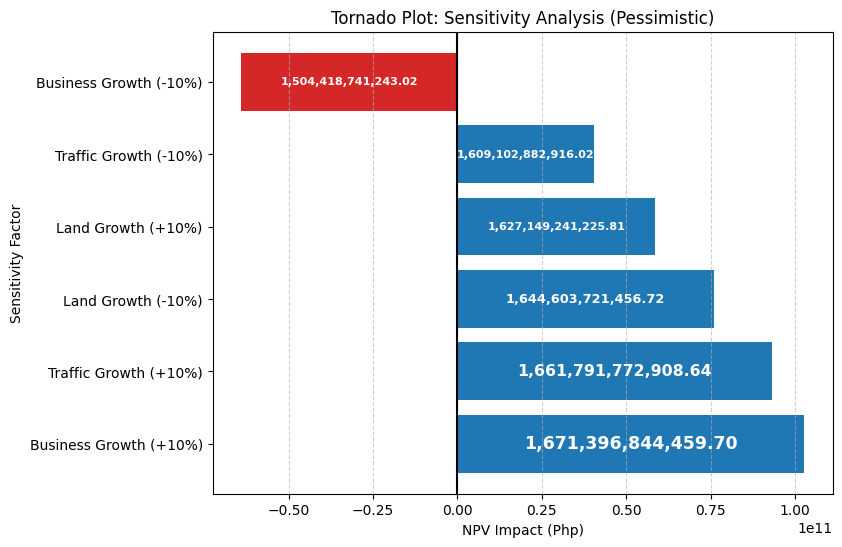


High Discount Volatility Scenario - NPV: 1,736,527,400,614.93 Php | BCR: 12.71


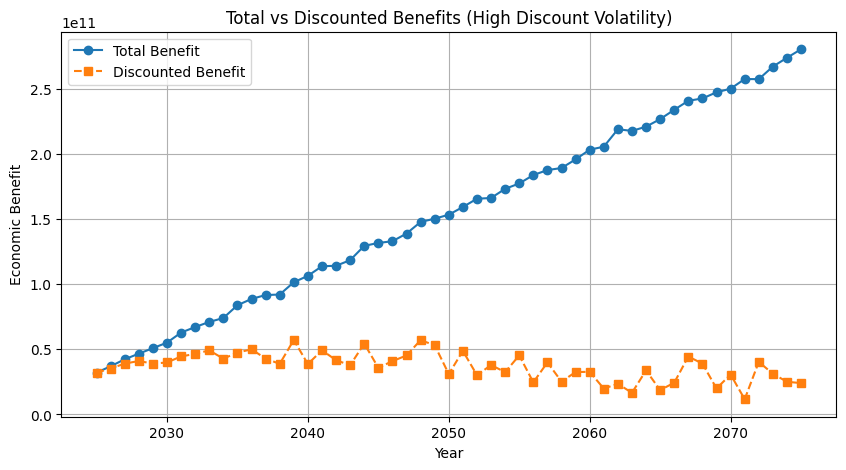

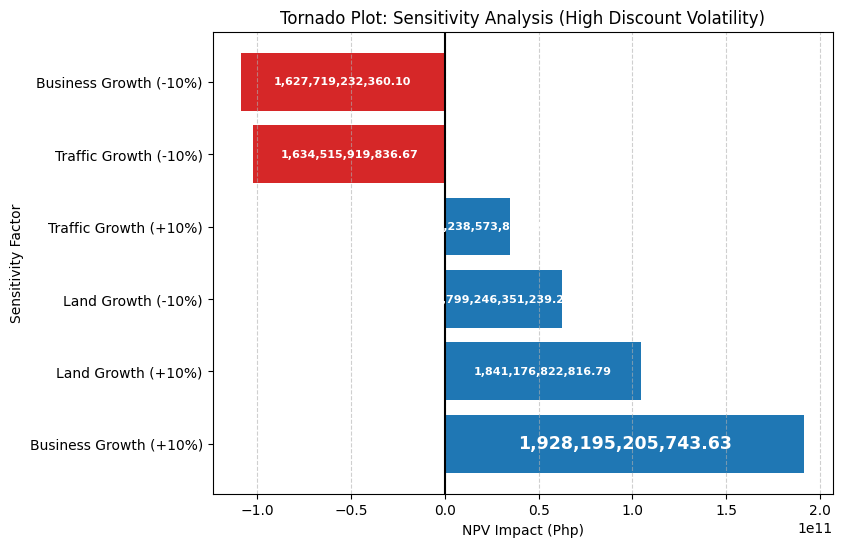

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import seaborn as sns

base_path = "/content/economic_forecast_results/"
os.makedirs(base_path, exist_ok=True)
years_forecast = np.arange(2025, 2076)

historical_years = np.arange(2014, 2024)
historical_land_growth = np.array([0.008, 0.0018, 0.0177, 0.00118, 0.00155, 0.00575, 0.00817, -0.00863, 0.00103, 0.0077])  # https://www.statista.com/statistics/1451182/philippines-quarterly-change-in-land-prices/
historical_business_growth = np.array([0.2136, 0.0827, 0.0811, 0.0028, 1.2539, 0.0013, 0.3312, 0.0032, 0.000, 0.0005]) # https://cmci.dti.gov.ph/data-portal.php, choose Hagonoy (BU), local economic growth
historical_traffic_growth = np.array([0.000, 0.010, 0.014, 0.010, 0.000, 0.0132, 0.0001, 0.0231, 0.0004, 0.0005]) # https://cmci.dti.gov.ph/data-portal.php, choose Hagonoy (BU), road network factor


def calibrate_vasicek(data):
    def neg_log_likelihood(params): # to prevent negative values in terms of inflation; used to measure the likelihood (probability) of a model given some data by minimizing the negative of the sum of squared errors,
        alpha, theta, sigma = params
        dt = 1 #difference per year
        residuals = np.diff(data) - alpha * (theta - data[:-1]) * dt #difference between the actual changes of inflation and the predicted changes of inflation
        return np.sum(residuals**2) # sum of all the squared residuals to get a single number that represents the total error; smaller sum means better prediction of model to actual data

    initial_guess = [0.1, np.mean(data), 0.02]
    result = minimize(neg_log_likelihood, initial_guess, bounds=[(0, None), (None, None), (0, None)])
    return result.x

alpha_land, theta_land, sigma_land = calibrate_vasicek(historical_land_growth)
alpha_business, theta_business, sigma_business = calibrate_vasicek(historical_business_growth)
alpha_traffic, theta_traffic, sigma_traffic = calibrate_vasicek(historical_traffic_growth)

def vasicek_forecast(alpha, theta, sigma, historical_data, years):
    last_value = historical_data[-1]
    forecasts = []
    for year in years:
        dt = year - 2024
        simulated_value = last_value + alpha * (theta - last_value) * dt + sigma * np.sqrt(dt) * np.random.normal()
        forecasts.append(simulated_value)
    return np.clip(forecasts, 0, None)

land_growth_forecast = vasicek_forecast(alpha_land, theta_land, sigma_land, historical_land_growth, years_forecast)
business_growth_forecast = vasicek_forecast(alpha_business, theta_business, sigma_business, historical_business_growth, years_forecast)
traffic_growth_forecast = vasicek_forecast(alpha_traffic, theta_traffic, sigma_traffic, historical_traffic_growth, years_forecast)

capex_php = 148.3e9
initial_land_value = (136.4 * 1000 * 6.70 * 6000) #kilometers covered by NALEX, multiplied by the span of the NALEX (6.7 km) (TRB, 2021), multiplied by the highest zonal value of Hagonoy, Bulacan (Php 6000 per sq. km.) (BIR, n.d.), multiplied by 1000 https://zonalvaluefinderph.com/zonal-values/?city=HAGONOY&province=BULACAN#
business_expansion = ((402416 * 1000 * 18.18) + (3838 * 1000 * 16.58) + (54806.57 * 40450073390 / 300345.65)) # # volume of production of agricultural products of Bulacan in metric tons (402,416 for palay, 3,838 for corn) multiplied by their unit price (Php 18.18 and Php 16.58 respectively), multiplied by 1000 each volume of production of aquaculture products of Bulacan in metric tons (54,806.57), multiplied by the aquaculture volume value (Php 40,450,073.39), divided by the volume of production of agricultural products in Region III (300,345.65 MT), as mentioned in the 2022 Report of the Bureau of Fisheries and Aquatic Resources.
traffic_savings = 2500000000.00 # https://www2.jica.go.jp/en/evaluation/pdf/2022_PH-P276_1_s.pdf
job_creation_impact = 32369246.51 * 136.4 #  Initial value of work from price/km of new road construction from Table 10 of DPWH: https://www.dpwh.gov.ph/dpwh/DPWH_ATLAS/Tables%20&%20Graphs%20(Roads)/Road%20Data%202016/ATLAS%202016/Table%201.4.htm

growth_scenarios = {
    "Optimistic": {"land": land_growth_forecast * 1.1, "business": business_growth_forecast * 1.1, "traffic": traffic_growth_forecast * 1.1},
    "Base Case": {"land": land_growth_forecast, "business": business_growth_forecast, "traffic": traffic_growth_forecast},
    "Pessimistic": {"land": land_growth_forecast * 0.9, "business": business_growth_forecast * 0.9, "traffic": traffic_growth_forecast * 0.9},
    "High Discount Volatility": {"land": land_growth_forecast, "business": business_growth_forecast, "traffic": traffic_growth_forecast, "discount_rate": np.random.uniform(0.03, 0.10, len(years_forecast))} # Simulated discount rate
}

def compute_economic_impact(growth_factors):
    data = []
    for i, year in enumerate(years_forecast):
        discount_rate = np.random.uniform(0.04, 0.07)  # Simulated discount rate
        discount_factor = 1 / ((1 + discount_rate) ** (year - 2025))
        land_value = initial_land_value * (1 + growth_factors["land"][i])
        business_value = business_expansion * (1 + growth_factors["business"][i])
        traffic_savings_yearly = traffic_savings * (1 + growth_factors["traffic"][i])
        job_impact = job_creation_impact * (1 + growth_factors["business"][i])
        total_benefit = land_value + business_value + traffic_savings_yearly + job_impact
        discounted_benefit = total_benefit * discount_factor
        data.append([year, land_value, business_value, traffic_savings_yearly, job_impact, total_benefit, discounted_benefit])
    return pd.DataFrame(data, columns=["Year", "Land Value", "Business Growth", "Traffic Savings", "Job Creation Impact", "Total Benefit", "Discounted Benefit"])

def compute_npv_bcr(df):
    npv = df["Discounted Benefit"].sum() - capex_php
    bcr = df["Discounted Benefit"].sum() / capex_php
    return npv, bcr

def tornado_plot(scenario, baseline_npv, sensitivity_results):    # tornado plot is used to display how sensitive the project's financials are to changes in land, business, and traffic growth rates.
    df_sensitivity = pd.DataFrame(list(sensitivity_results.items()), columns=["Factor", "NPV"])
    df_sensitivity["Change"] = df_sensitivity["NPV"] - baseline_npv
    df_sensitivity = df_sensitivity.sort_values(by="Change", ascending=False)
    plt.figure(figsize=(8, 6))
    bars = plt.barh(df_sensitivity["Factor"], df_sensitivity["Change"],
                    color=['#1f77b4' if x > 0 else '#d62728' for x in df_sensitivity["Change"]])

    plt.axvline(0, color='black', linewidth=1.5)
    plt.xlabel("NPV Impact (Php)")
    plt.ylabel("Sensitivity Factor")
    plt.title(f"Tornado Plot: Sensitivity Analysis ({scenario})")
    plt.grid(axis="x", linestyle="--", alpha=0.6)

    for bar, npv_value in zip(bars, df_sensitivity["NPV"]):
        x_pos = bar.get_width() / 2
        text_color = "white" if abs(bar.get_width()) > (max(abs(df_sensitivity["Change"])) * 0.15) else "black"
        font_size = max(8, min(14, abs(bar.get_width()) / (max(abs(df_sensitivity["Change"])) * 0.08)))
        plt.text(x_pos, bar.get_y() + bar.get_height()/2, f"{npv_value:,.2f}",
                 va='center', ha='center', fontsize=font_size, color=text_color, fontweight='bold')

    plt.show()

for scenario, growth_factors in growth_scenarios.items():
    df = compute_economic_impact(growth_factors)
    npv, bcr = compute_npv_bcr(df)
    df.to_csv(f"{base_path}highway_economic_forecast_{scenario}.csv", index=False)
    print(f"\n{scenario} Scenario - NPV: {npv:,.2f} Php | BCR: {bcr:.2f}")
    plt.figure(figsize=(10, 5))
    plt.plot(df["Year"], df["Total Benefit"], label="Total Benefit", linestyle='-', marker='o')
    plt.plot(df["Year"], df["Discounted Benefit"], label="Discounted Benefit", linestyle='--', marker='s')
    plt.xlabel("Year")
    plt.ylabel("Economic Benefit")
    plt.title(f"Total vs Discounted Benefits ({scenario})")
    plt.legend()
    plt.grid()
    plt.show()
    sensitivity_factors = {
        "Land Growth (+10%)": compute_npv_bcr(compute_economic_impact({**growth_factors, "land": growth_factors["land"] * 1.1}))[0],
        "Land Growth (-10%)": compute_npv_bcr(compute_economic_impact({**growth_factors, "land": growth_factors["land"] * 0.9}))[0],
        "Business Growth (+10%)": compute_npv_bcr(compute_economic_impact({**growth_factors, "business": growth_factors["business"] * 1.1}))[0],
        "Business Growth (-10%)": compute_npv_bcr(compute_economic_impact({**growth_factors, "business": growth_factors["business"] * 0.9}))[0],
        "Traffic Growth (+10%)": compute_npv_bcr(compute_economic_impact({**growth_factors, "traffic": growth_factors["traffic"] * 1.1}))[0],
        "Traffic Growth (-10%)": compute_npv_bcr(compute_economic_impact({**growth_factors, "traffic": growth_factors["traffic"] * 0.9}))[0],
    }
    tornado_plot(scenario, npv, sensitivity_factors)


[2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]

Optimistic Scenario - NPV: 1,880,735,296,695.26 Php | BCR: 13.68


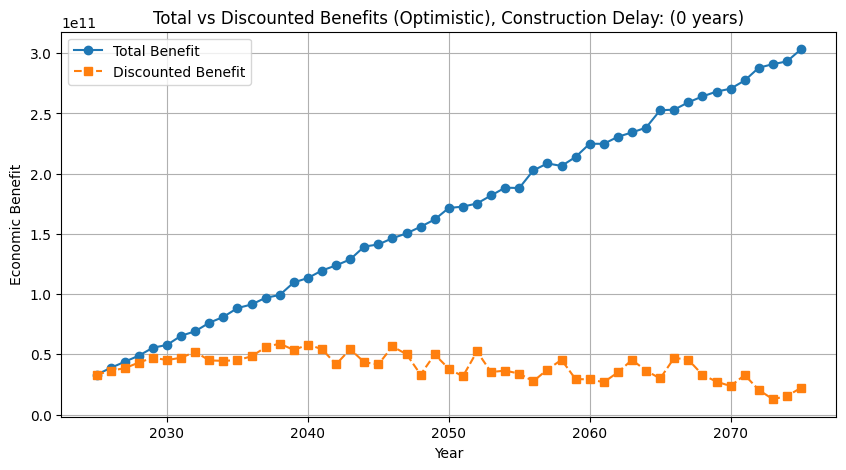

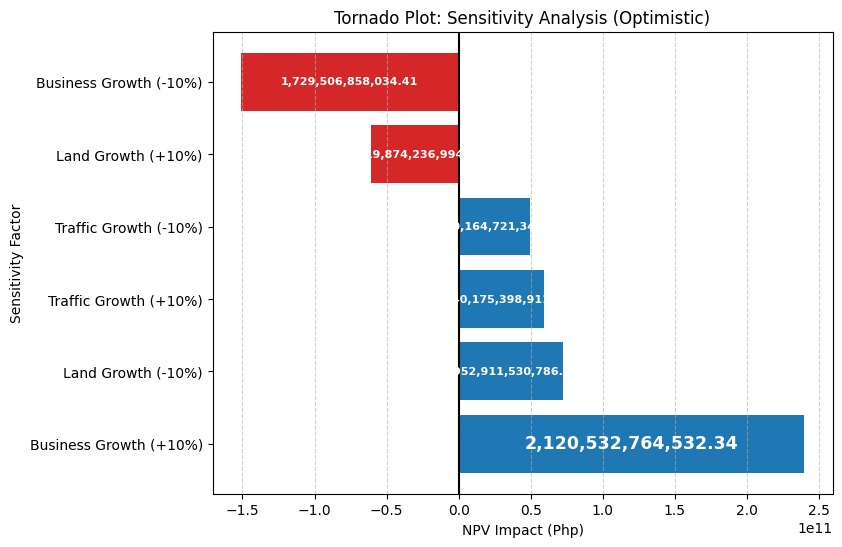


Base Case Scenario - NPV: 1,815,385,174,557.36 Php | BCR: 13.24


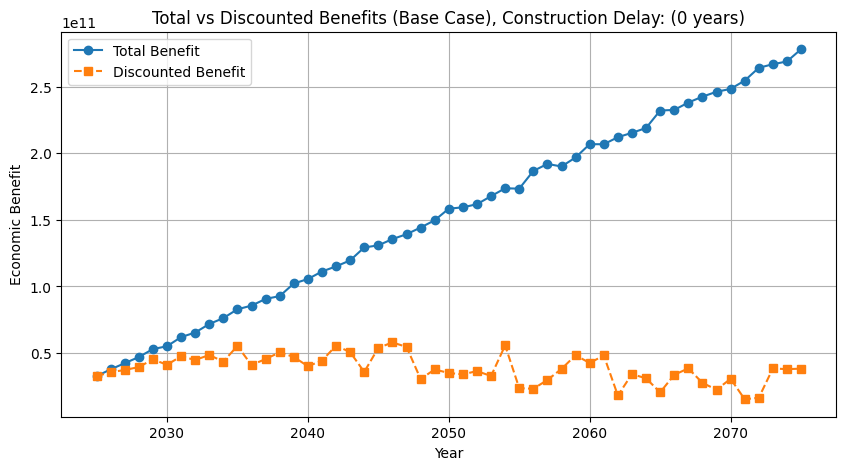

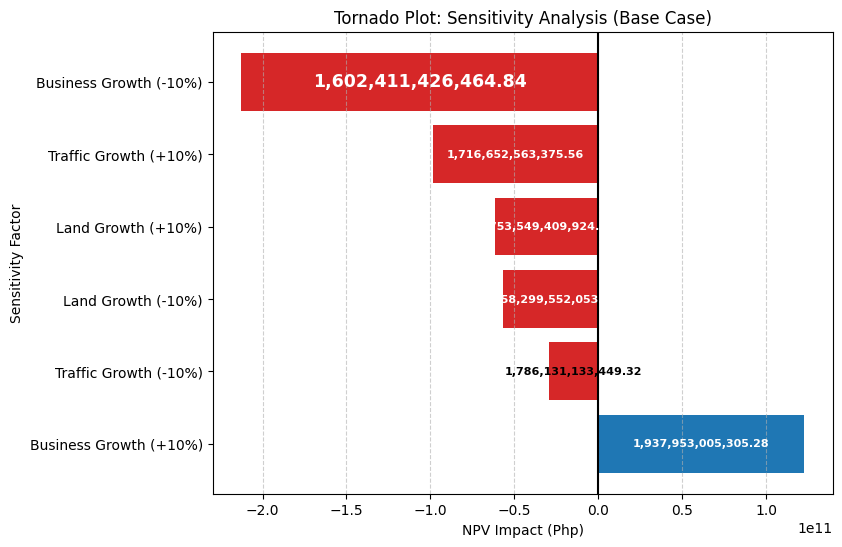


Pessimistic Scenario - NPV: 1,606,473,009,577.44 Php | BCR: 11.83


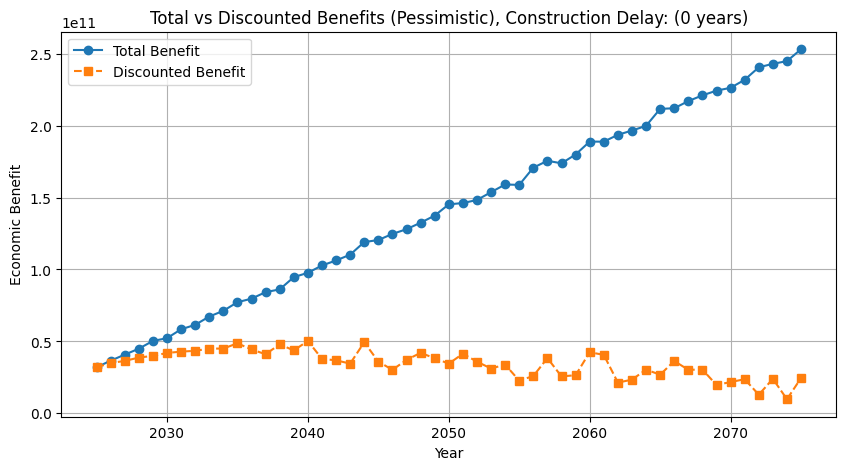

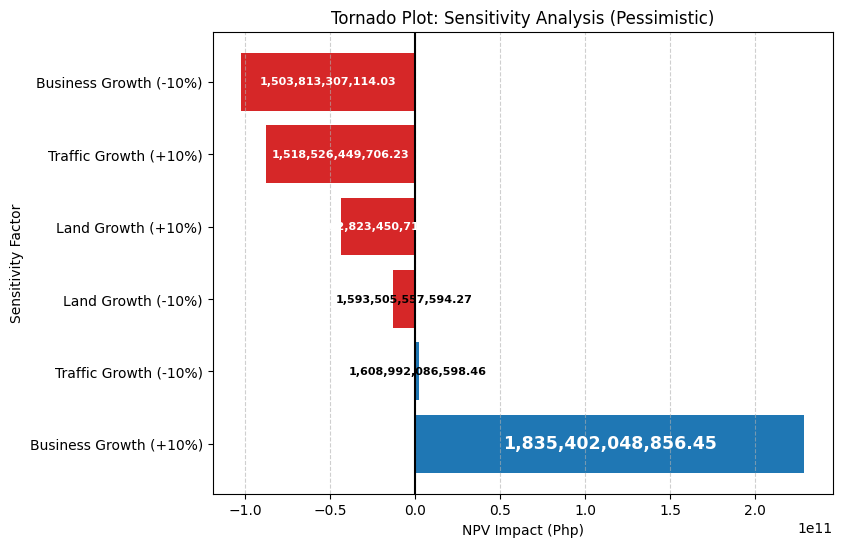


High Discount Volatility Scenario - NPV: 1,692,618,867,510.04 Php | BCR: 12.41


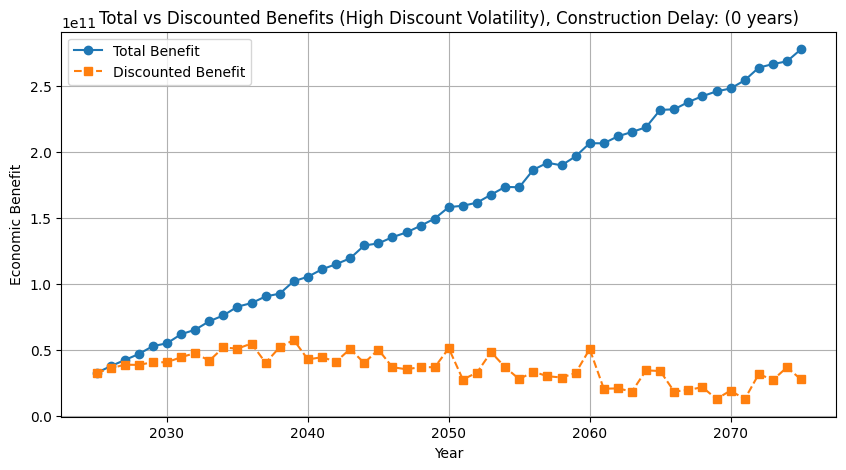

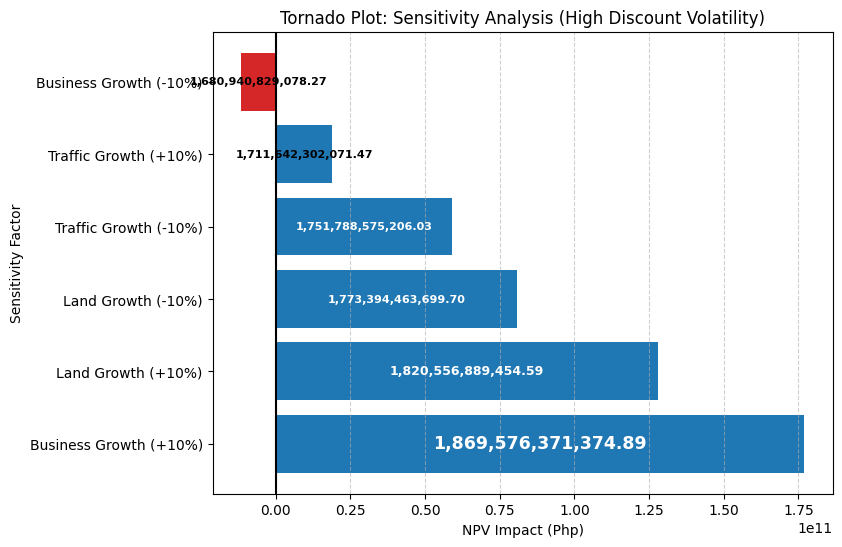


Optimistic Scenario - NPV: 1,535,569,488,077.60 Php | BCR: 11.35


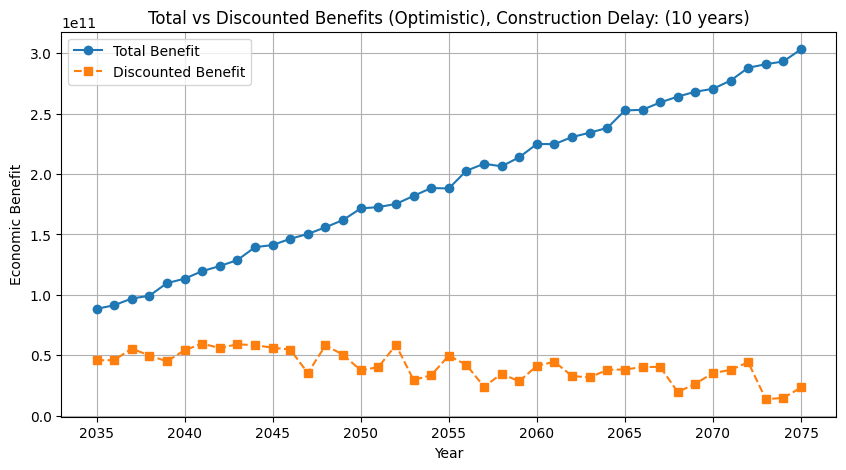

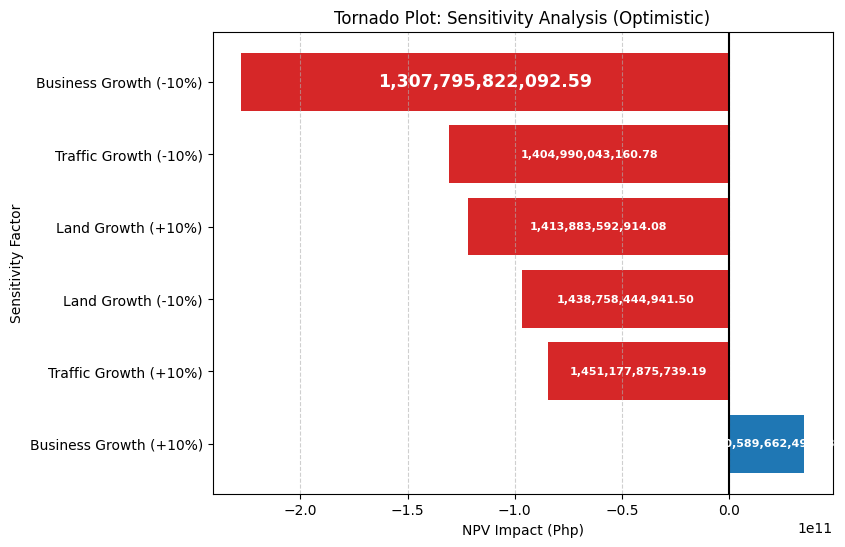


Base Case Scenario - NPV: 1,329,497,450,777.42 Php | BCR: 9.96


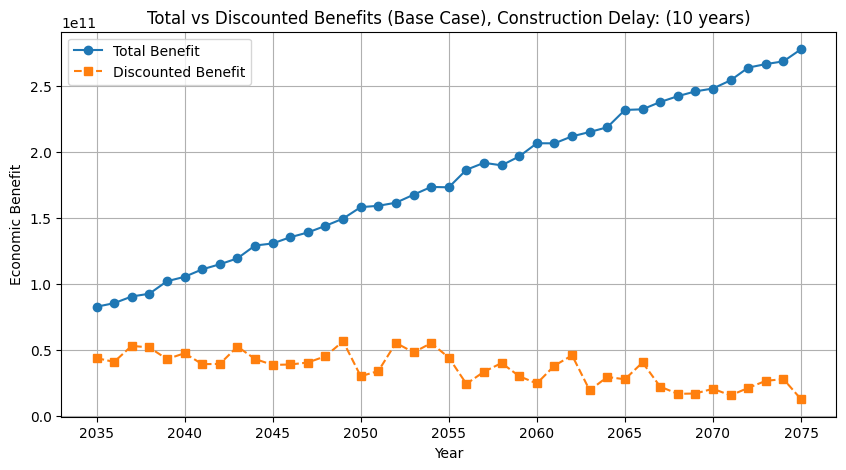

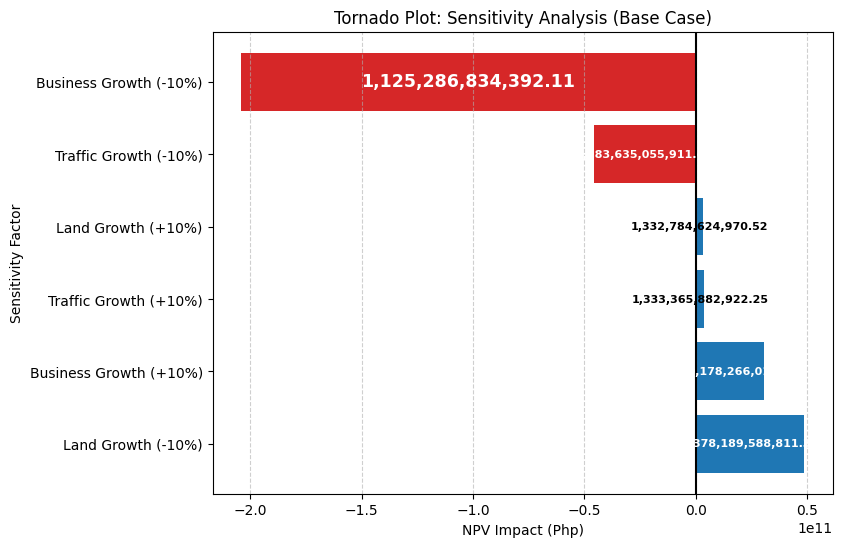


Pessimistic Scenario - NPV: 1,219,675,224,810.58 Php | BCR: 9.22


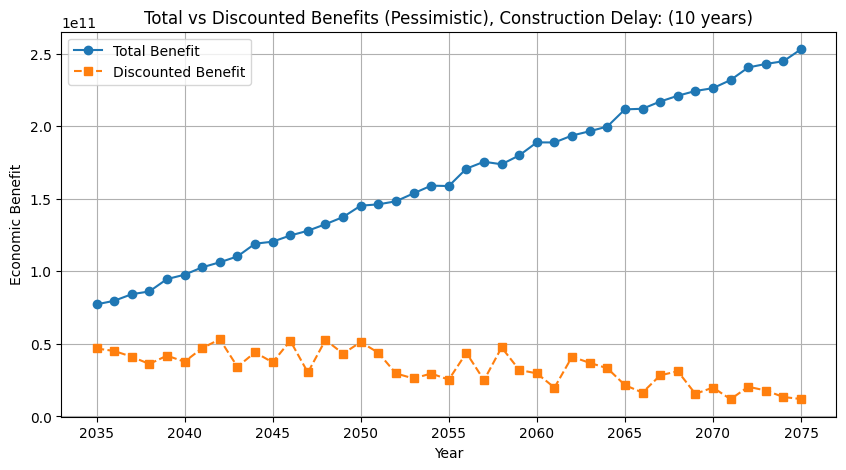

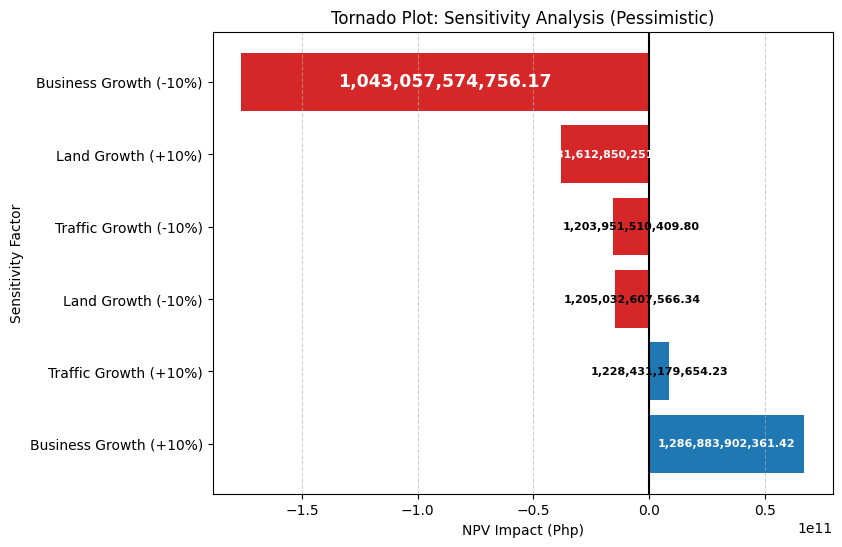


High Discount Volatility Scenario - NPV: 1,395,220,836,132.25 Php | BCR: 10.41


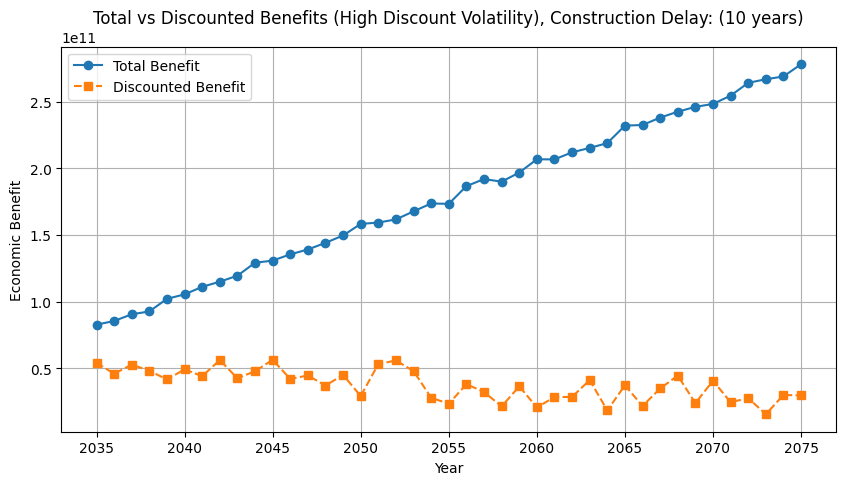

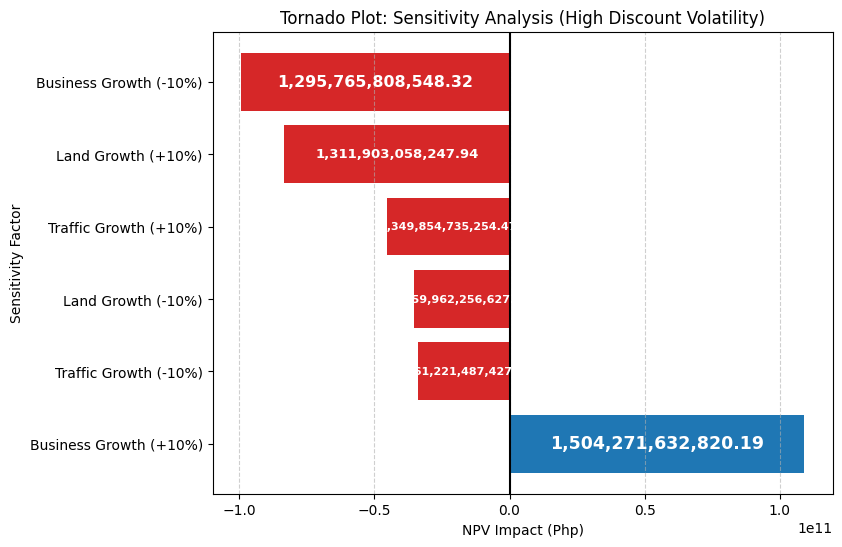


Optimistic Scenario - NPV: 1,085,682,128,334.48 Php | BCR: 8.32


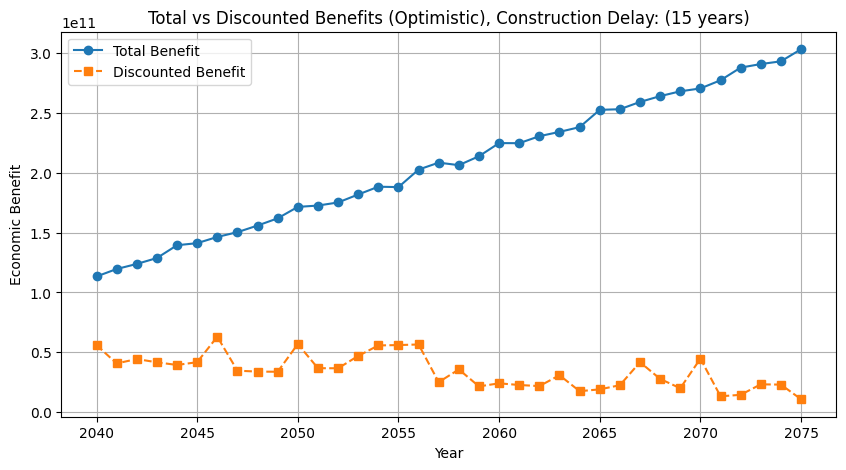

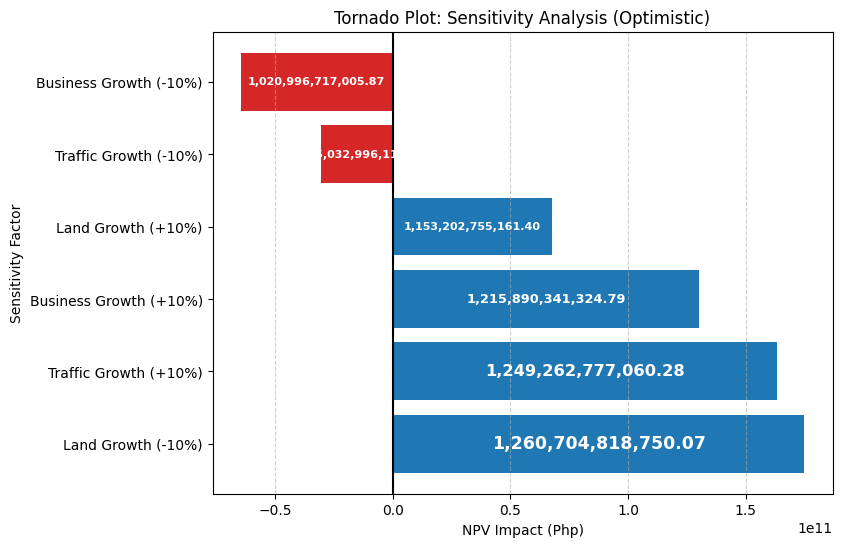


Base Case Scenario - NPV: 1,062,658,919,618.81 Php | BCR: 8.17


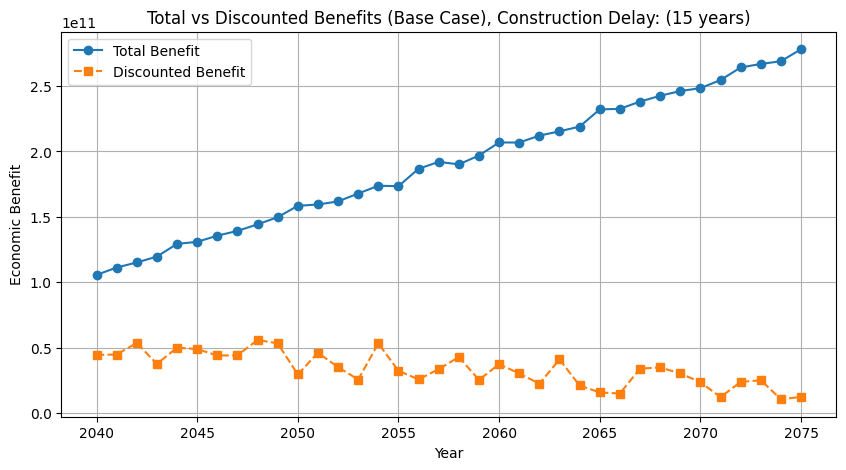

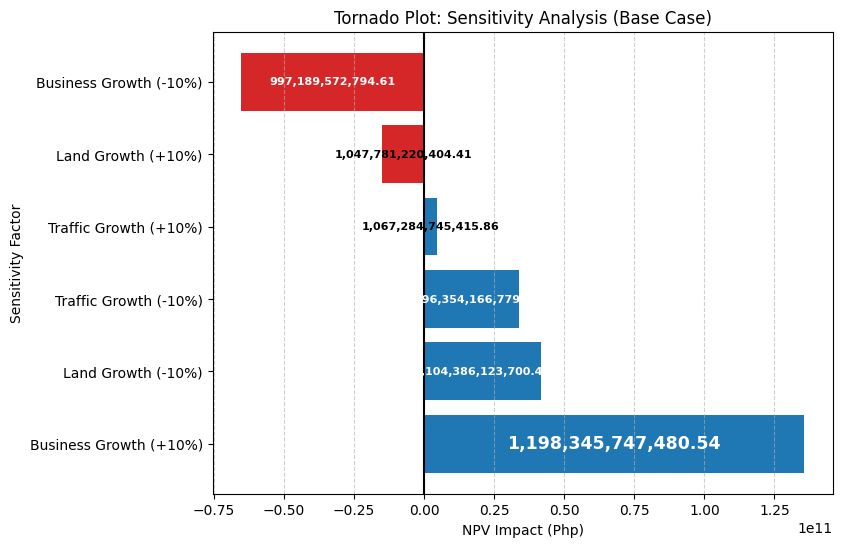


Pessimistic Scenario - NPV: 1,011,841,719,433.48 Php | BCR: 7.82


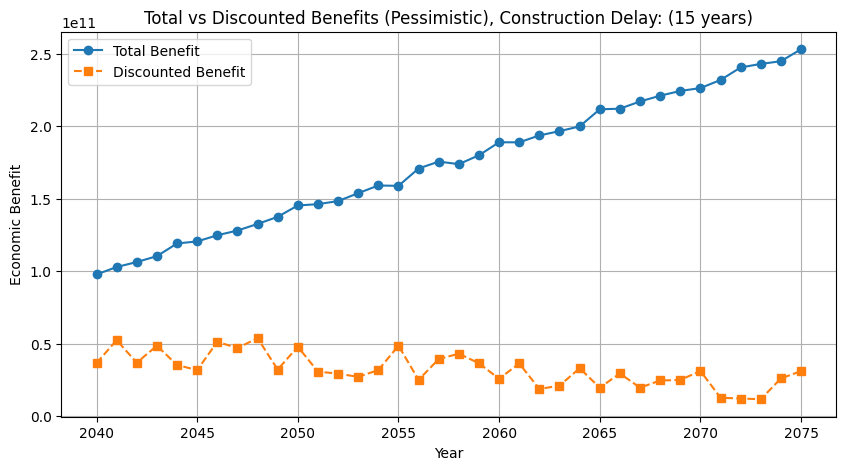

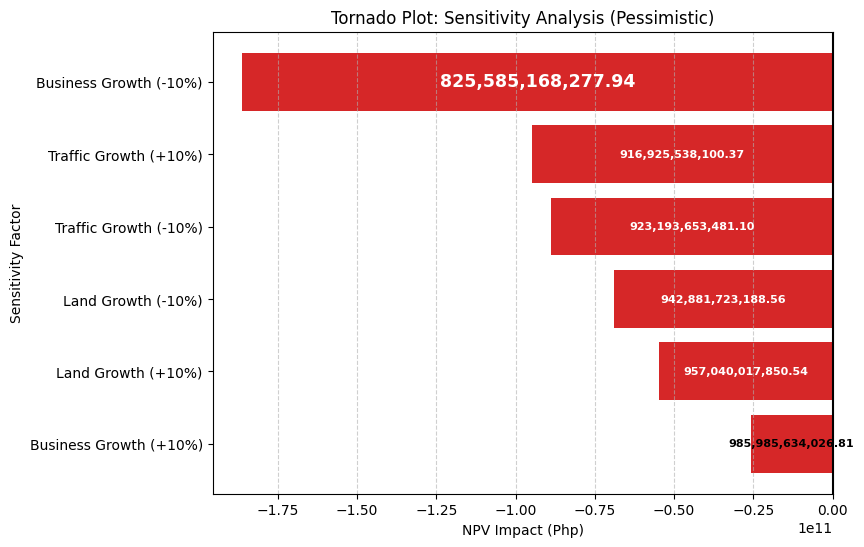


High Discount Volatility Scenario - NPV: 1,168,768,545,301.85 Php | BCR: 8.88


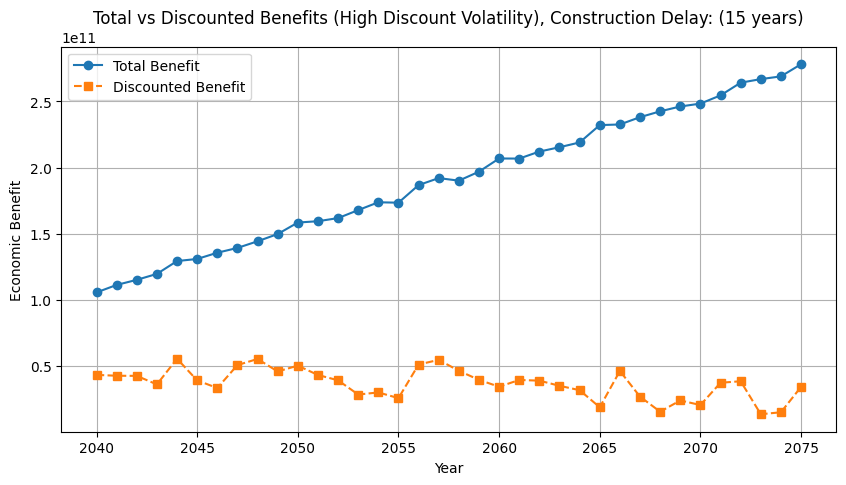

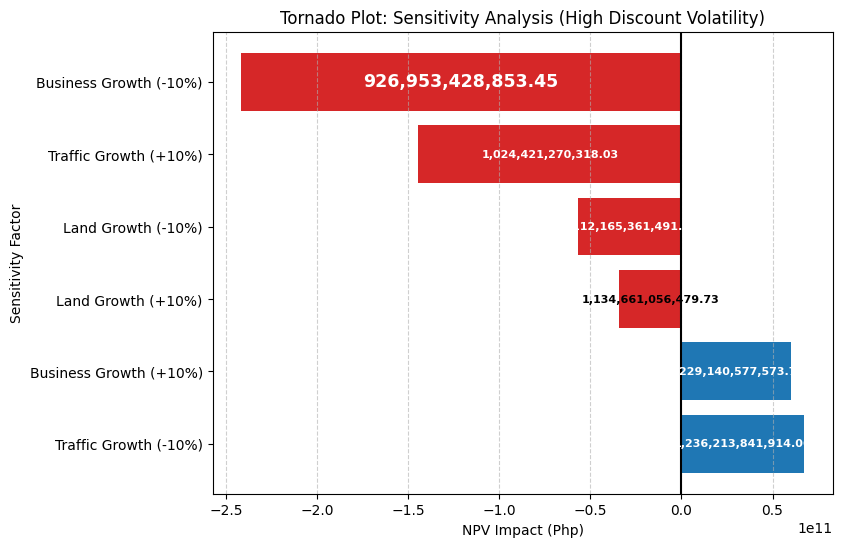


Optimistic Scenario - NPV: 781,664,305,933.23 Php | BCR: 6.27


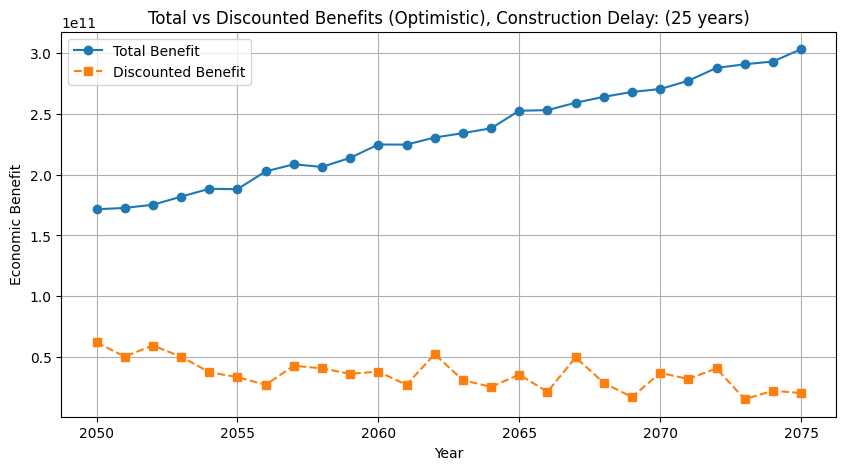

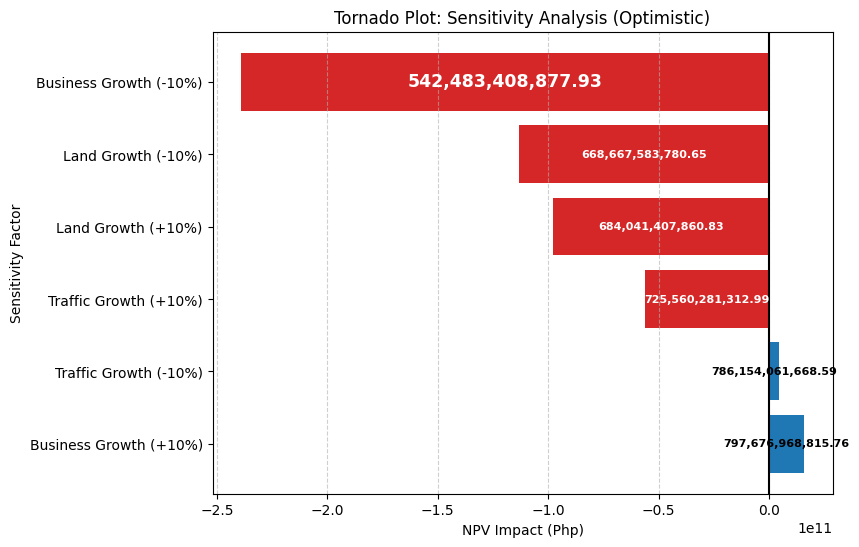


Base Case Scenario - NPV: 648,851,717,628.15 Php | BCR: 5.38


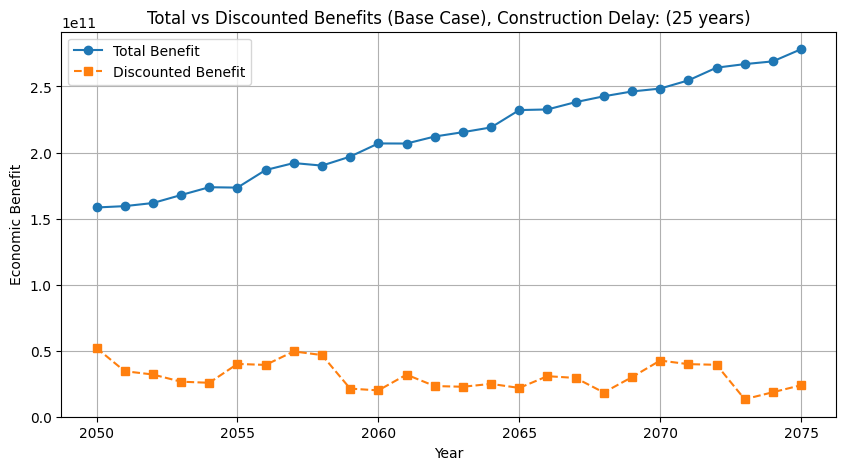

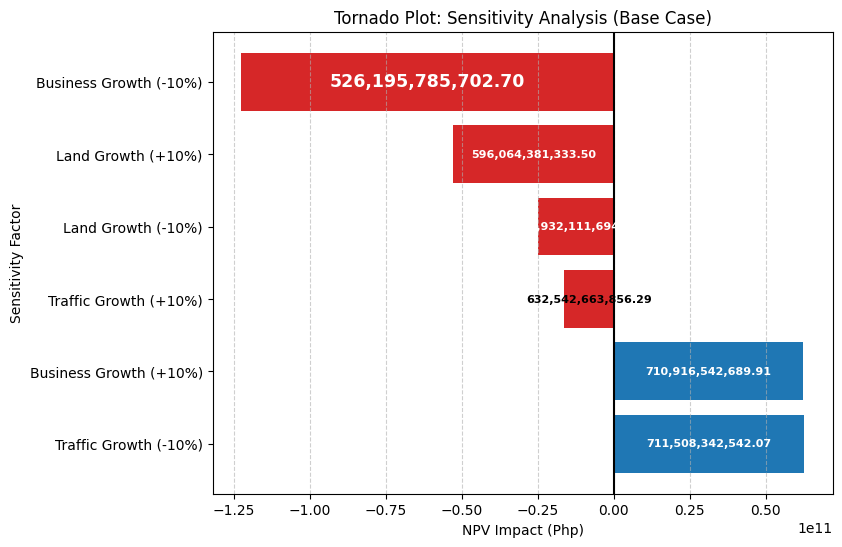


Pessimistic Scenario - NPV: 562,482,824,883.40 Php | BCR: 4.79


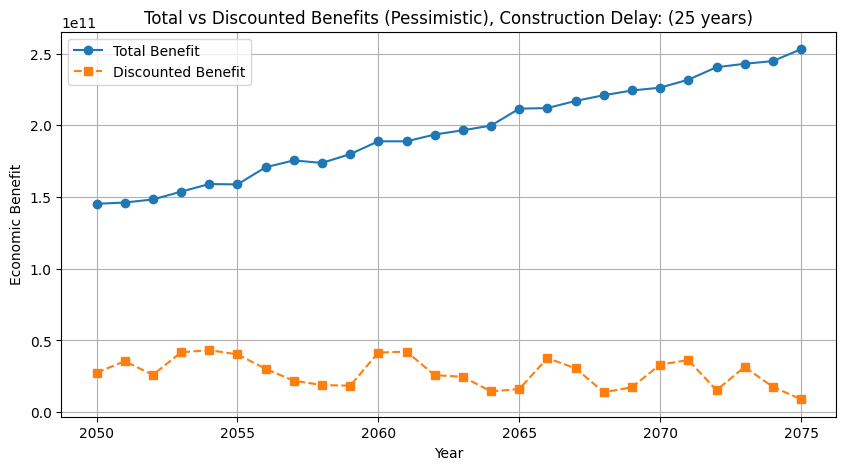

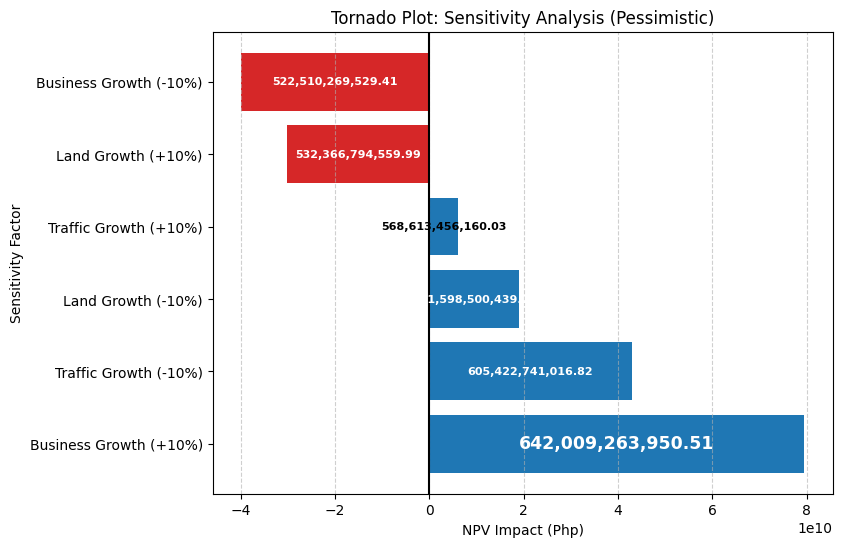


High Discount Volatility Scenario - NPV: 564,443,757,102.09 Php | BCR: 4.81


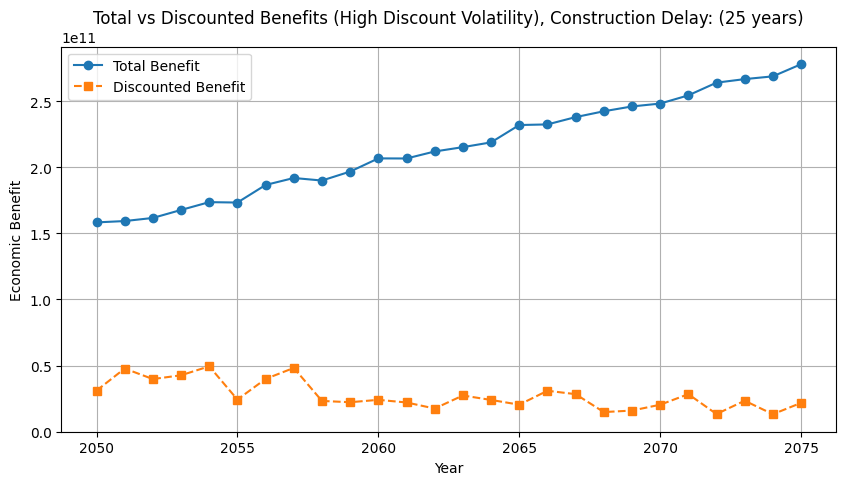

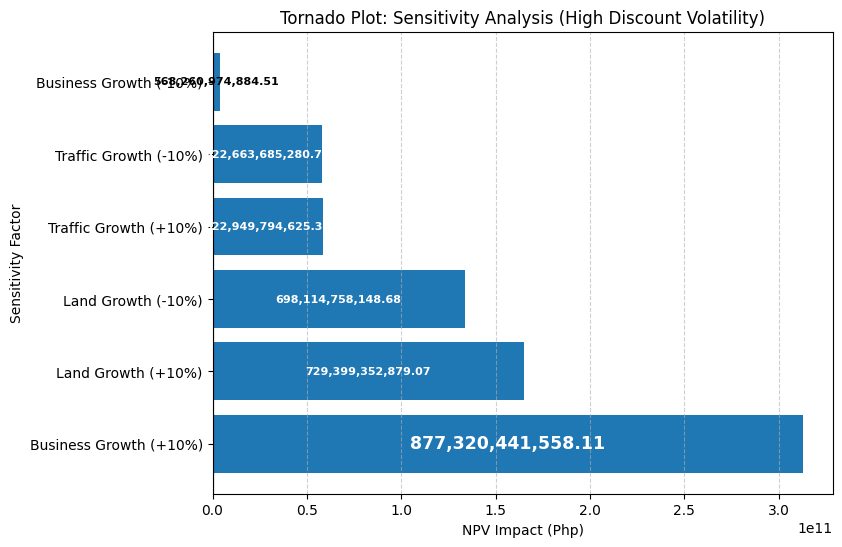

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import seaborn as sns

base_path = "/content/economic_forecast_results/"
os.makedirs(base_path, exist_ok=True)
years_forecast = np.arange(2025, 2076)

historical_years = np.arange(2014, 2024)
print(historical_years)
historical_land_growth = np.array([0.008, 0.0018, 0.0177, 0.00118, 0.00155, 0.00575, 0.00817, -0.00863, 0.00103, 0.0077]) # https://www.statista.com/statistics/1451182/philippines-quarterly-change-in-land-prices/
historical_business_growth = np.array([0.2136, 0.0827, 0.0811, 0.0028, 1.2539, 0.0013, 0.3312, 0.0032, 0.000, 0.0005]) #  https://cmci.dti.gov.ph/data-portal.php, choose Hagonoy (BU), local economic growth
historical_traffic_growth = np.array([0.000, 0.010, 0.014, 0.010, 0.000, 0.0132, 0.0001, 0.0231, 0.0004, 0.0005]) # https://cmci.dti.gov.ph/data-portal.php, choose Hagonoy (BU), road network factor

delay_scenarios = [0, 10, 15, 25] #interval of delay of the completion of NALEX project
def calibrate_vasicek(data):
    def neg_log_likelihood(params):   # to prevent negative values in terms of inflation; used to measure the likelihood (probability) of a model given some data by minimizing the negative of the sum of squared errors
        alpha, theta, sigma = params
        dt = 1 #difference in years
        residuals = np.diff(data) - alpha * (theta - data[:-1]) * dt #difference between the actual changes of inflation and the predicted changes of inflation
        return np.sum(residuals**2) # sum of all the squared residuals to get a single number that represents the total error; smaller sum means better prediction of model to actual data

    initial_guess = [0.1, np.mean(data), 0.02]
    result = minimize(neg_log_likelihood, initial_guess, bounds=[(0, None), (None, None), (0, None)])
    return result.x

alpha_land, theta_land, sigma_land = calibrate_vasicek(historical_land_growth)
alpha_business, theta_business, sigma_business = calibrate_vasicek(historical_business_growth)
alpha_traffic, theta_traffic, sigma_traffic = calibrate_vasicek(historical_traffic_growth)

def vasicek_forecast(alpha, theta, sigma, historical_data, years):
    last_value = historical_data[-1]
    forecasts = []
    for year in years:
        dt = year - 2024
        simulated_value = last_value + alpha * (theta - last_value) * dt + sigma * np.sqrt(dt) * np.random.normal()
        forecasts.append(simulated_value)
    return np.clip(forecasts, 0, None)

land_growth_forecast = vasicek_forecast(alpha_land, theta_land, sigma_land, historical_land_growth, years_forecast)
business_growth_forecast = vasicek_forecast(alpha_business, theta_business, sigma_business, historical_business_growth, years_forecast)
traffic_growth_forecast = vasicek_forecast(alpha_traffic, theta_traffic, sigma_traffic, historical_traffic_growth, years_forecast)

capex_php = 148.3e9
initial_land_value = (136.4 * 1000 * 6.70 * 6000) #kilometers covered by NALEX, multiplied by the span of the NALEX (6.7 km) (TRB, 2021), multiplied by the highest zonal value of Hagonoy, Bulacan (Php 6000 per sq. km.) (BIR, n.d.), multiplied by 1000. https://zonalvaluefinderph.com/zonal-values/?city=HAGONOY&province=BULACAN#
business_expansion = ((402416 * 1000 * 18.18) + (3838 * 1000 * 16.58) + (54806.57 * 40450073390 / 300345.65)) #with values mentioned in the report by the 2022 Philippine Statistics Authority (PSA) Quickstat report for Bulacan, formula is the sum of the following ;volume of production of agricultural products of Bulacan in metric tons (402,416 for palay, 3,838 for corn) multiplied by their unit price (Php 18.18 and Php 16.58 respectively), multiplied by 1000 each; volume of production of aquaculture products of Bulacan in metric tons (54,806.57), multiplied by the aquaculture volume value (Php 40,450,073.39), divided by the volume of production of agricultural products in Region III (300,345.65 MT), as mentioned in the 2022 Report of the Bureau of Fisheries and Aquatic Resources.
 # https://www.bfar.da.gov.ph/wp-content/uploads/2024/02/2022-Philippine-Fisheries-Profile.pdf; https://rsso03.psa.gov.ph/sites/default/files/2023-QS-14-02.pdf
traffic_savings = 2500000000.00 # https://www2.jica.go.jp/en/evaluation/pdf/2022_PH-P276_1_s.pdf
job_creation_impact = 32369246.51 * 136.4 # Table 10, https://www.dpwh.gov.ph/dpwh/DPWH_ATLAS/Tables%20&%20Graphs%20(Roads)/Road%20Data%202016/ATLAS%202016/Table%201.4.htm ; new road construction

growth_scenarios = {
    "Optimistic": {"land": land_growth_forecast * 1.1, "business": business_growth_forecast * 1.1, "traffic": traffic_growth_forecast * 1.1},
    "Base Case": {"land": land_growth_forecast, "business": business_growth_forecast, "traffic": traffic_growth_forecast},
    "Pessimistic": {"land": land_growth_forecast * 0.9, "business": business_growth_forecast * 0.9, "traffic": traffic_growth_forecast * 0.9},
    "High Discount Volatility": {"land": land_growth_forecast, "business": business_growth_forecast, "traffic": traffic_growth_forecast, "discount_rate": np.random.uniform(0.03, 0.10, len(years_forecast))} # projected inflation
}

def compute_economic_impact(growth_factors, delay):
    data = []
    for i, year in enumerate(years_forecast):
        if year < 2025 + delay:
            total_benefit, discounted_benefit = 0, 0
        else:
            discount_rate = np.random.uniform(0.04, 0.07)  # Initial discount rate 4 to 8%, like in codeblock 1
            discount_factor = 1 / ((1 + discount_rate) ** (year - 2025))
            land_value = initial_land_value * (1 + growth_factors["land"][i])
            business_value = business_expansion * (1 + growth_factors["business"][i])
            traffic_savings_yearly = traffic_savings * (1 + growth_factors["traffic"][i])
            job_impact = job_creation_impact * (1 + growth_factors["business"][i])
            total_benefit = land_value + business_value + traffic_savings_yearly + job_impact
            discounted_benefit = total_benefit * discount_factor
            data.append([year, land_value, business_value, traffic_savings_yearly, job_impact, total_benefit, discounted_benefit])

    return pd.DataFrame(data, columns=["Year", "Land Value", "Business Growth", "Traffic Savings", "Job Creation Impact", "Total Benefit", "Discounted Benefit"])

def compute_npv_bcr(df):
    npv = df["Discounted Benefit"].sum() - capex_php
    bcr = df["Discounted Benefit"].sum() / capex_php
    return npv, bcr

def tornado_plot(scenario, baseline_npv, sensitivity_results): # tornado plot is used to display how sensitive the project's financials are to changes in land, business, and traffic growth rates.
    df_sensitivity = pd.DataFrame(list(sensitivity_results.items()), columns=["Factor", "NPV"])
    df_sensitivity["Change"] = df_sensitivity["NPV"] - baseline_npv
    df_sensitivity = df_sensitivity.sort_values(by="Change", ascending=False)
    plt.figure(figsize=(8, 6))
    bars = plt.barh(df_sensitivity["Factor"], df_sensitivity["Change"],
                    color=['#1f77b4' if x > 0 else '#d62728' for x in df_sensitivity["Change"]])

    plt.axvline(0, color='black', linewidth=1.5)
    plt.xlabel("NPV Impact (Php)")
    plt.ylabel("Sensitivity Factor")
    plt.title(f"Tornado Plot: Sensitivity Analysis ({scenario})")
    plt.grid(axis="x", linestyle="--", alpha=0.6)

    for bar, npv_value in zip(bars, df_sensitivity["NPV"]):
        x_pos = bar.get_width() / 2
        text_color = "white" if abs(bar.get_width()) > (max(abs(df_sensitivity["Change"])) * 0.15) else "black"
        font_size = max(8, min(14, abs(bar.get_width()) / (max(abs(df_sensitivity["Change"])) * 0.08)))
        plt.text(x_pos, bar.get_y() + bar.get_height()/2, f"{npv_value:,.2f}",
                 va='center', ha='center', fontsize=font_size, color=text_color, fontweight='bold')

    plt.show()

for delay in delay_scenarios:
    for scenario, growth_factors in growth_scenarios.items():
        df = compute_economic_impact(growth_factors, delay)
        npv, bcr = compute_npv_bcr(df)
        df.to_csv(f"{base_path}highway_economic_forecast_{scenario}.csv", index=False)
        print(f"\n{scenario} Scenario - NPV: {npv:,.2f} Php | BCR: {bcr:.2f}")
        plt.figure(figsize=(10, 5))
        plt.plot(df["Year"], df["Total Benefit"], label="Total Benefit", linestyle='-', marker='o')
        plt.plot(df["Year"], df["Discounted Benefit"], label="Discounted Benefit", linestyle='--', marker='s')
        plt.xlabel("Year")
        plt.ylabel("Economic Benefit")
        plt.title(f"Total vs Discounted Benefits ({scenario}), Construction Delay: ({delay} years)")
        plt.legend()
        plt.grid()
        plt.show()
        sensitivity_factors = {
            "Land Growth (+10%)": compute_npv_bcr(compute_economic_impact({**growth_factors, "land": growth_factors["land"] * 1.1}, delay))[0],
            "Land Growth (-10%)": compute_npv_bcr(compute_economic_impact({**growth_factors, "land": growth_factors["land"] * 0.9}, delay))[0],
            "Business Growth (+10%)": compute_npv_bcr(compute_economic_impact({**growth_factors, "business": growth_factors["business"] * 1.1}, delay))[0],
            "Business Growth (-10%)": compute_npv_bcr(compute_economic_impact({**growth_factors, "business": growth_factors["business"] * 0.9}, delay))[0],
            "Traffic Growth (+10%)": compute_npv_bcr(compute_economic_impact({**growth_factors, "traffic": growth_factors["traffic"] * 1.1}, delay))[0],
            "Traffic Growth (-10%)": compute_npv_bcr(compute_economic_impact({**growth_factors, "traffic": growth_factors["traffic"] * 0.9}, delay))[0],
        }
        tornado_plot(scenario, npv, sensitivity_factors)

# +- of 10% is only to show the degree of sensitivity of the abovementioned variables's NPV